## Create Graph Plots of the Vector Images in Tempest

The graphics in Tempest are generated using Atari's 'Quadrascan' vector technology. The images are all defined using a series of vectors. A vector in this case is an `(x,y)` value pair that moves the beam in an x,y direction to a new point on the screen. A series of vectors moving from point to point around the screen will eventually form a complete image.

There are a bunch of different macros used to encode the vector commands that define the images. Most of the image definitions appear in `ALVROM.MAC`, and a few others in `ALDIS2.MAC`.


[This page](https://arcarc.xmission.com/Tech/neilw_xy.txt) gives a good overview of the different vector commands.

Here is an example of a vector command in action. There are two types of commands for drawing a vector. The first we'll cover is the simplest:

```
Bit Key:

          X - X coordinate bits
          Y - Y coordinate bits
          I - Vector intensity(brightness) bits
          
Draw short relative vector 0x40     010YYYYY IIIXXXXX
```

This command draws a line from the beam's current position by moving it to the X,Y position specified by the vector command. The brightness of the line is specified by the intensity bits.

For example if X is 0, Y is 16, and our intensity value is 6. We would encode this as follows:

```
    16    6    0
010 10000 110  00000
```
This gives us a hex value of 48C0.

Here we have a snippet from the assembly listing of `ANVGAN.MAC`, where the vectors for all the alphanumerics used in Tempest are defined. This is the letter `A` specified by a series of vector commands. On the left hand side are encoded vector commands, on the right hand side are the assembly statements they have been assembled from. 

```
     3+  3000  48C0                     CHAR.A: VCTR 0,16,.BRITE
     4+  3002  44C4                             VCTR 8,8,.BRITE
     5+  3004  5CC4                             VCTR 8,-8,.BRITE
     6+  3006  58C0                             VCTR 0,-16,.BRITE
     7+  3008  4418                             VCTR -16,8,0
     8+  300A  40C8                             VCTR 16,0,.BRITE
     9+  300C  5C04                             VCTR 8,-8,0
```
`VCTR` is a macro that looks as follows:
```asm
	.MACRO	VCTR DX,DY,ZZ
	...1=DX
	...2=DY
	.IF	 LT,...1		;IF NEGATIVE X
	...1=-DX
	.ENDC
	.IF	 LT,...2		;IF NEGATIVE Y
	...2=-DY
	.ENDC
	...5=...1!...2
	.IF	NE,...1+...2			;IF X AND Y ARE 0 - SKIP SHOR VECTOR
	.IF	 EQ,...5&^H0FFE1
	.WORD	^H4000+<ZZ*^H20>+<DX/2&^H1F>+<DY*^H80&^H1F00>
	.MEXIT
	.ENDC
	.ENDC
	.WORD	DY&^H1FFF,<ZZ*^H2000>+<DX&^H1FFF>
	.ENDM
```

`VCTR` takes three arguments: X,Y, and intensity. In the following python snippet we emulate its operation to encode the three arguments into the appropriate two-byte vector command.

In [143]:
import tabulate
vecs = [(x.split()[2],x.split()[-1].replace(".BRITE","6")) 
     for x in """
     3+  3000  48C0                     CHAR.A: VCTR 0,16,.BRITE
     4+  3002  44C4                             VCTR 8,8,.BRITE
     5+  3004  5CC4                             VCTR 8,-8,.BRITE
     6+  3006  58C0                             VCTR 0,-16,.BRITE
     7+  3008  4418                             VCTR -16,8,0
     8+  300A  40C8                             VCTR 16,0,.BRITE
     9+  300C  5C04                             VCTR 8,-8,0
""".splitlines()[1:]]

data=[["Original","Parms","Calculated"]]
for fvec, rvec in vecs:
    x,y,i = [int(x) for x in rvec.split(',')]
    cvec = 0x4000
    cvec += i * 0x20
    cvec += int(abs(x)/2) & 0x1F
    if x < 0:
        cvec |= 0x10
    cvec += (y*0x80) & 0x1F00
    if y < 0:
        cvec |= 0x1000
    data +=[[fvec,rvec,hex(cvec)]]

table = tabulate.tabulate(data, tablefmt='html')
table


Original,Parms,Calculated
48C0,"0,16,6",0x48c0
44C4,"8,8,6",0x44c4
5CC4,"8,-8,6",0x5cc4
58C0,"0,-16,6",0x58c0
4418,"-16,8,0",0x4418
40C8,"16,0,6",0x40c8
5C04,"8,-8,0",0x5c04


Let's decode some vector commands into line graphs. Here are the functions we'll use to do this. They will take the raw assembly commands from the Tempest source listing and convert them into line-graphs that show us the images they encode.

Our end result in each case is a graph of x,y vertices that form the image in question.

In [144]:
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt
import os

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 150

colors = {
    "TURQOI":"CYAN",
    "PDIWHI":"WHITE",
    "PDIRED":"RED",
    "PDIYEL":"YELLOW",
    "":"WHITE",
}

def scvec(old_x,old_y,color,x,y,i=0):
    c = "BLACK" if i == 0 else colors.get(color,color)
    vec=(x-old_x,y-old_y,c)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def calvec(old_x,old_y,x,y,CALBRITE):
    vec=(x-old_x,y-old_y,CALBRITE)
    old_x = x
    old_y = y
    return (vec,old_x,old_y)

def vctr(color,x,y,i=""):
    x,y=int(x,16),int(y,16)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

def parse_calvec_parms(parms):
    x,y = [x.replace('.','') for x in parms[0].split(',')]
    x = 0x00 if x == "NXE" else int(x,16)
    y = int(y,16)
    return (x,y)

def parse_vector_commands(vector_data,default_color="red"):
    # Read in the vector commands from the Tempest source code
    # and translate them into a series of vectors, i.e. a  list of 
    # tuples of the form (x,y,color).
    # This list can then be transformed into a series of x,y co-ordinates
    # for plotting on a graph.
    color = ""
    vecs = []
    old_x,old_y = 0,0
    CALBRITE = "BLACK"
    for l in vector_data.splitlines():
        if not l.strip():
            continue
        tokens = l.strip().split()
        cmd, parms = tokens[0],tokens[1:]
        if cmd in ["ICVEC","ICALVE"]:
            vecs+=[(0,0,"BLACK")]
            old_x,old_y=0,0
        elif cmd == "CNTR":
            vecs+=[(0,0,"BLACK")]
        elif cmd == "CSTAT":
            color = parms[0]
        elif cmd == "VCTR":
            parms = parms[0].split(',')
            vecs+=[vctr(color,*parms)]
        elif cmd == "VEC":
            # A 0,0 origin is implicit.
            if len(vecs) == 0:
                vecs+=[(0,0,default_color)]    
            parms = parms[0].split(',')
            vecs+=[vctr(default_color,*parms)]
        elif cmd == "SCVEC":
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
        elif cmd == "VDOT":
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd == "SCDOT":
            # SCVEC
            parms = [int(x.replace('.',''),16) for x in parms[0].split(',')]
            vec,old_x,old_y = scvec(old_x,old_y,color,*parms)
            vecs+=[vec]
            # VCTR
            vecs+=[vctr(color,"0","0","CB")]
        elif cmd in [".BRITE=VARBRT",".BRITE =VARBRT"]:
            CALBRITE=default_color
        elif cmd in [".BRITE=0",".BRITE =0"]:
            CALBRITE="BLACK"
        elif cmd == "CALVEC":
            x,y = parse_calvec_parms(parms)
            vec,old_x,old_y = calvec(old_x,old_y,x,y,CALBRITE)
            vecs+=[vec]
    return vecs

def vectors_to_coords(vectors):
    # Turns a series of vectors into a series of x,y co-ordinates
    # or vertices.
    xs,ys,cs=[],[],[]
    px,py,pc=0,0,None
    for x,y,c in vectors:
        # If we're changing color, add a vertex with the
        # new color at the old position.
        if pc and c != pc:
            xs+=[px]
            ys+=[py]
            cs+=[c]
        # Calculate the position of the new vertex
        px+=x
        py+=y
        xs+=[px]
        ys+=[py]
        cs+=[c]
        pc=c
    return list(zip(xs,ys,cs))

def plot_vertices(verts,points=""):
    # Plot a series of vertices onto a graph. In other words,
    # create an image from them.
    _, ax = plt.subplots()
    last_x,last_y=[],[]
    for k,g in groupby(verts, key=itemgetter(2)):
        l = list(g)
        xs,ys,_ =zip(*l)
        # Don't paint the vectors marked as black, 
        # we're just moving the beam.
        alpha = 0 if k == "BLACK" else 1
        ax.plot(xs,ys,points+'-',color=k,alpha=alpha)

def tabulateVecsAndVerts(vectors,vertices):
    data =[["Vector X", "Vector Y", "Vertex X", "Vertex Y"]]
    for (vx,vy,_),(x,y,_) in zip(vectors,vertices):
        data +=[[str(vx),str(vy),str(x),str(y),]]
    table = tabulate.tabulate(data, tablefmt='html')
    return table

Original,Parms,Calculated
0,0,0x4020
-1,-3,0x5e30
-3,39,0x5331
-32,-36,0x5e30
18,-64,0x5029
-14,62,0x5f37
11,5,0x4225
5,-21,0x5522
-2,24,0x4c31
13,13,0x4626


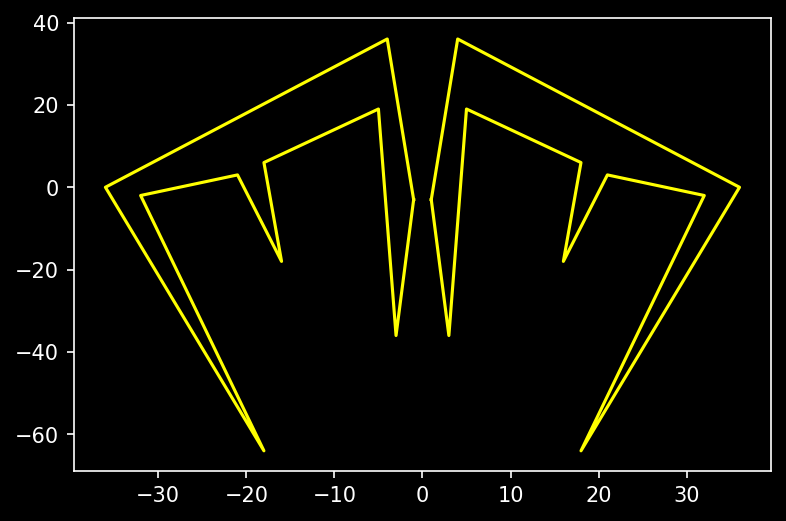

In [145]:
vector_data = """
ENER21:
	ICALVE
	CALVEC -1,-3
	.BRITE=VARBRT
	CALVEC -4,24.
	CALVEC -24.,0
	CALVEC -12.,-40.
	CALVEC -20.,-2
	CALVEC -15.,3
	CALVEC -10.,-12.
	CALVEC -12.,6
	CALVEC -5,13.
	CALVEC -3,-24.
	CALVEC -1,-3
	.BRITE=0
	CALVEC 1,-3
	.BRITE=VARBRT
	CALVEC 3,-24.
	CALVEC 5,13.
	CALVEC 12.,6
	CALVEC 10.,-12.
	CALVEC 15.,3
	CALVEC 20.,-2
	CALVEC 12.,-40.
	CALVEC 24.,0
	CALVEC 4,24.
	CALVEC 1,-3
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)

data=[["Original","Parms","Calculated"]]
for x,y,_ in vectors:
    i = 1
    cvec = 0x4000
    cvec += i * 0x20
    cvec += int(abs(x)/2) & 0x1F
    if x < 0:
        cvec |= 0x10
    cvec += (y*0x80) & 0x1F00
    if y < 0:
        cvec |= 0x1000
    data +=[[x,y,hex(cvec)]]
table = tabulate.tabulate(data, tablefmt='html')
table


## Images from ALDIS2.MAC

These are the vector images for the main enemies and the player's 'claw'. They are single color, so easy to define. They use the `VEC` macro for encoding the X, Y, and intensity values that define each vector. 
```asm
	.MACRO VEC UX,UZ,UI
	.NARG NUM
	...ONF=0
	.IIF EQ,NUM-3,...ONF=UI
	.IIF EQ,NUM-2,...ONF=1
	...PUV=UZ
	...UV=UX
	...SPU=0
	...SUV=0
	.IF LT,...PUV
	...PUV=-<...PUV>
	...SPU=80
	.ENDC
	.IF LT,...UV
	...UV=-<...UV>
	...SUV=40
	.ENDC
	.BYTE <...SPU>!<...SUV>!<...PUV*8>!<...UV>,...ONF
	.ENDM
```
Each vector moves the beam from position to position across the screen and draws a line to each new position (unless the intensity is defined as zero, when no line is drawn).

To graph these we create a list of the vectors (`parse_vector_commands`), convert these to a list of x,y co-ordinates (or vetices) (`vectors_to_coords`) and then use these to plot a graph between the x,y positions in our chosen color.

Vector X,Vector Y,Vertex X,Vertex Y
0,0,0,0
4,1,4,1
4,-1,8,0
-2,1,6,1
1,1,7,2
-3,-1,4,1
-3,1,1,2
1,-1,2,1
-2,-1,0,0


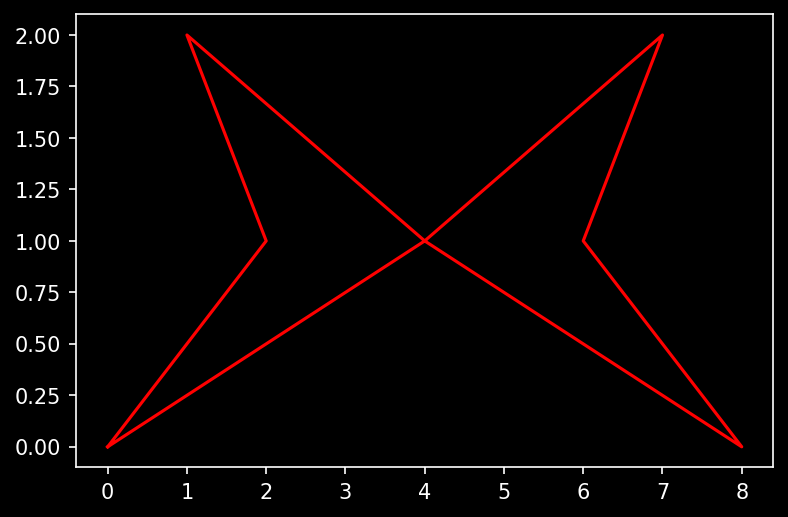

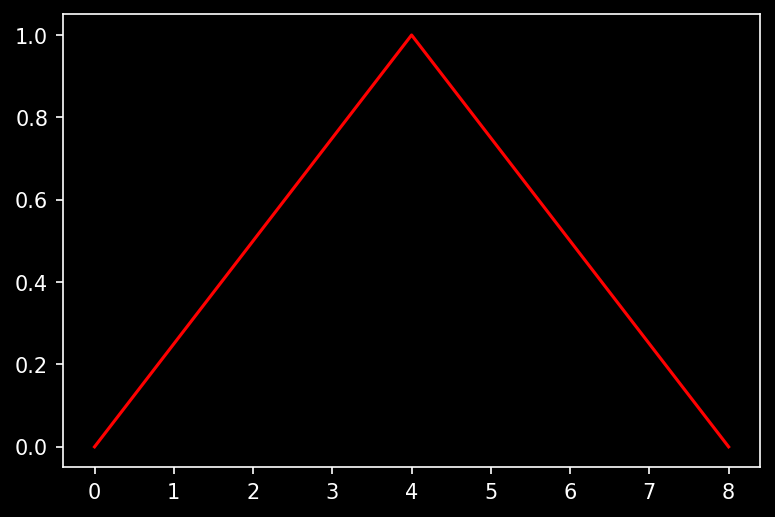

In [146]:
vector_data = """
INVA1S:
	VEC 4,1,1
	VEC 4,-1,1
	VEC -2,1
	VEC 1,1
	VEC -3,-1
	VEC -3,1
	VEC 1,-1
	VEC -2,-1
"""
vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


plot_vertices(vertices[:3])
tabulateVecsAndVerts(vectors,vertices)
    


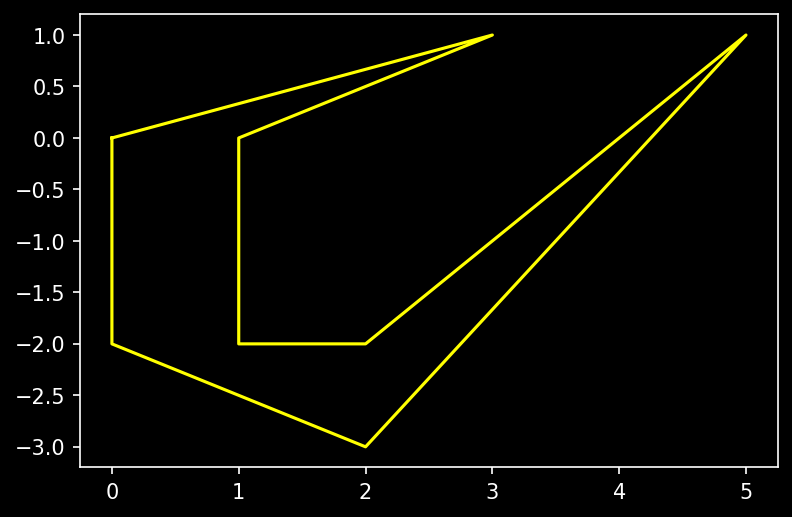

In [147]:
vector_data = """
NCRS1S:
	VEC 0,-2
	VEC 2,-1
	VEC 3,4
	VEC -3,-3
	VEC -1,0
	VEC 0,2
	VEC 2,1
	VEC -3,-1
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


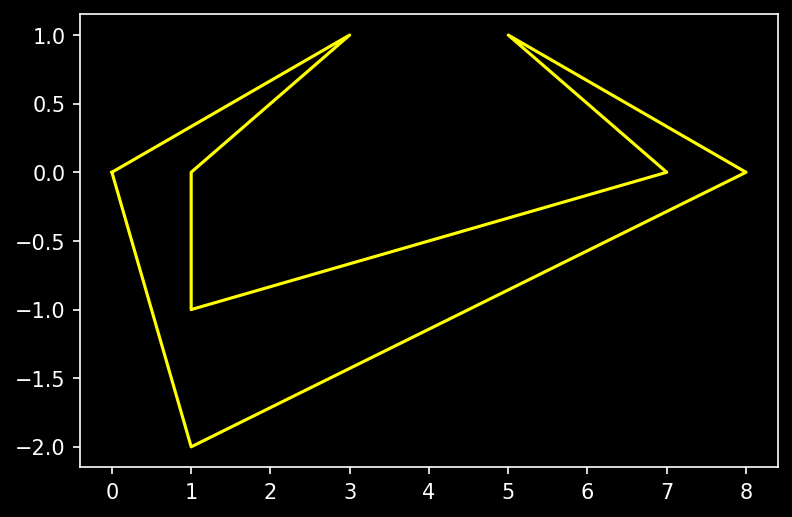

In [148]:
vector_data = """
NCRS2S:
	VEC 1,-2
	VEC 7,2
	VEC -3,1
	VEC 2,-1
	VEC -6,-1
	VEC 0,1
	VEC 2,1
	VEC -3,-1
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


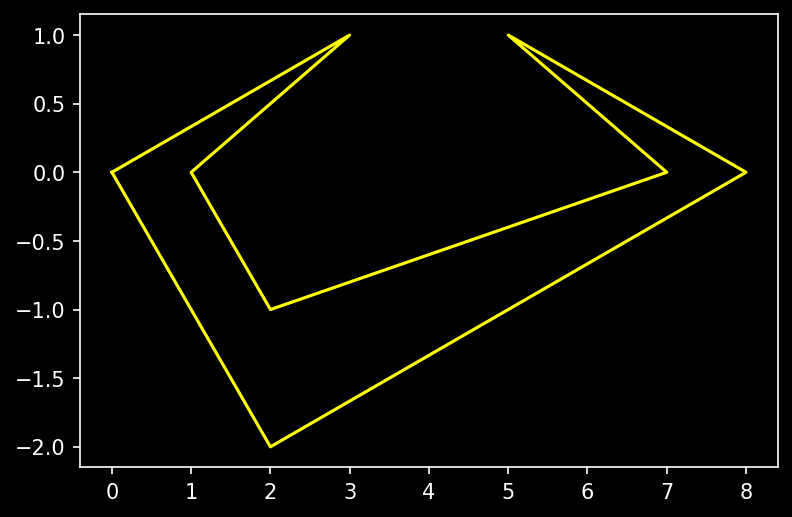

In [149]:
vector_data = """
NCRS3S:
	VEC 2,-2
	VEC 6,2
	VEC -3,1
	VEC 2,-1
	VEC -5,-1
	VEC -1,1
	VEC 2,1
	VEC -3,-1
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


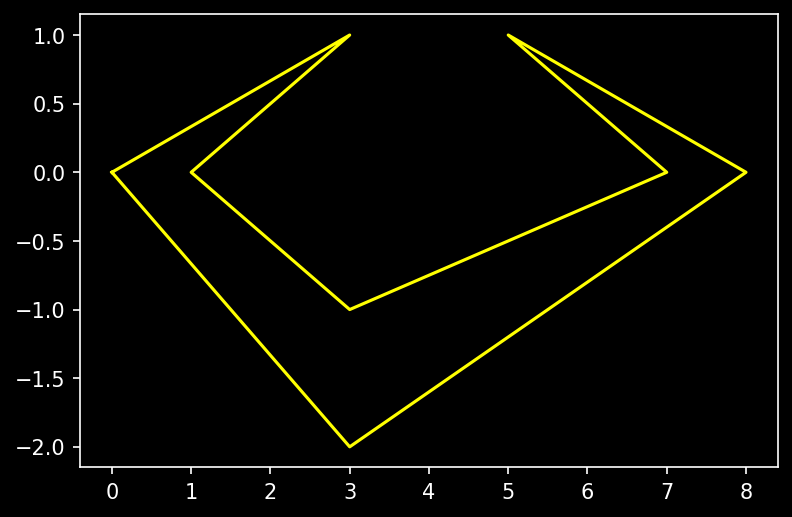

In [150]:
vector_data = """
NCRS4S:
	VEC 3,-2
	VEC 5,2
	VEC -3,1
	VEC 2,-1
	VEC -4,-1
	VEC -2,1
	VEC 2,1
	VEC -3,-1
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


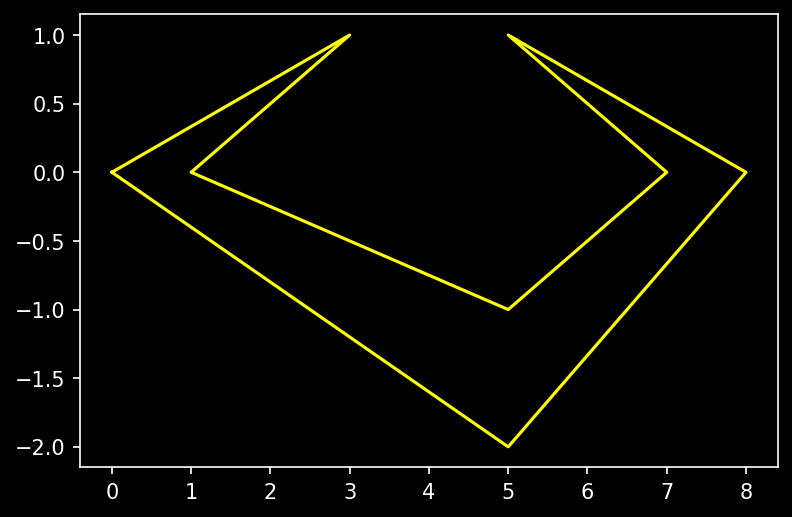

In [151]:
vector_data = """
NCRS5S:
	VEC 5,-2
	VEC 3,2
	VEC -3,1
	VEC 2,-1
	VEC -2,-1
	VEC -4,1
	VEC 2,1
	VEC -3,-1
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


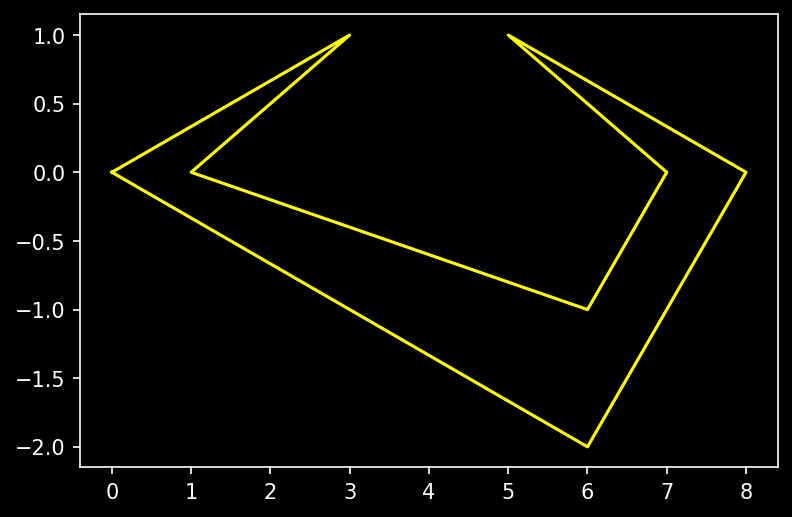

In [152]:
vector_data = """
NCRS6S:
	VEC 6,-2
	VEC 2,2
	VEC -3,1
	VEC 2,-1
	VEC -1,-1
	VEC -5,1
	VEC 2,1
	VEC -3,-1
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


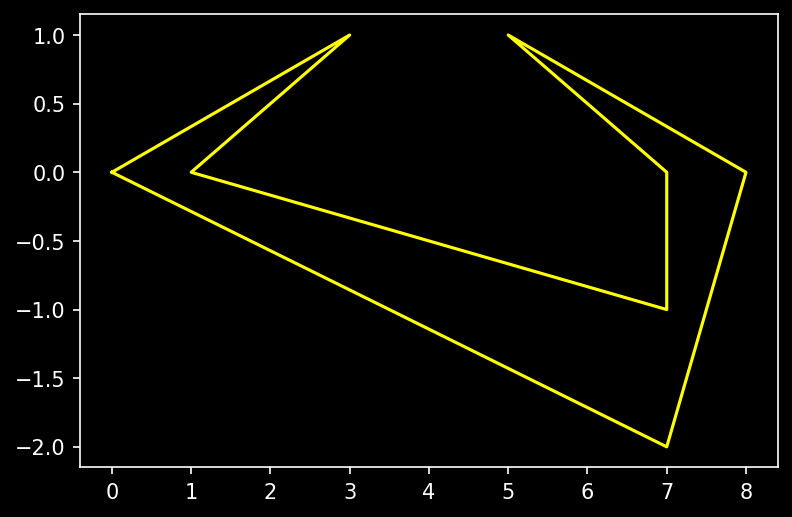

In [153]:
vector_data = """
NCRS7S:
	VEC 7,-2
	VEC 1,2
	VEC -3,1
	VEC 2,-1
	VEC 0,-1
	VEC -6,1
	VEC 2,1
	VEC -3,-1
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


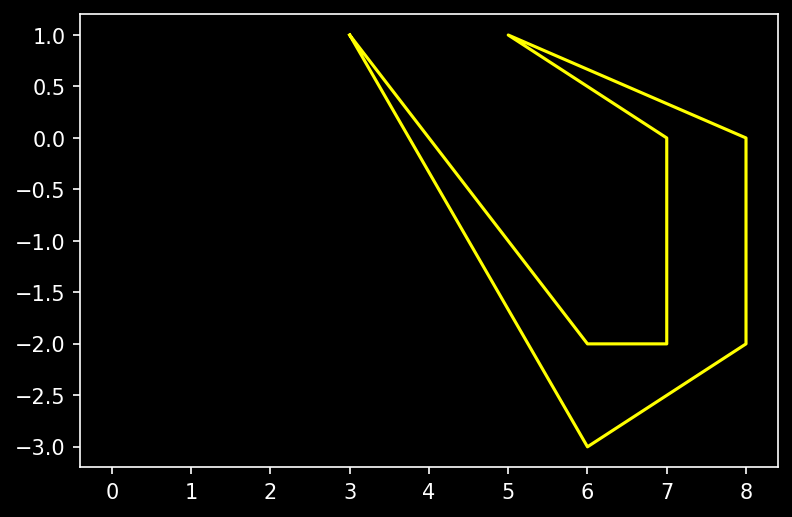

In [154]:
vector_data = """
NCRS8S:
	VEC 3,1,0
	VEC 3,-4
	VEC 2,1
	VEC 0,2
	VEC -3,1
	VEC 2,-1
	VEC 0,-2
	VEC -1,0
	VEC -3,3
"""
vectors = parse_vector_commands(vector_data,default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


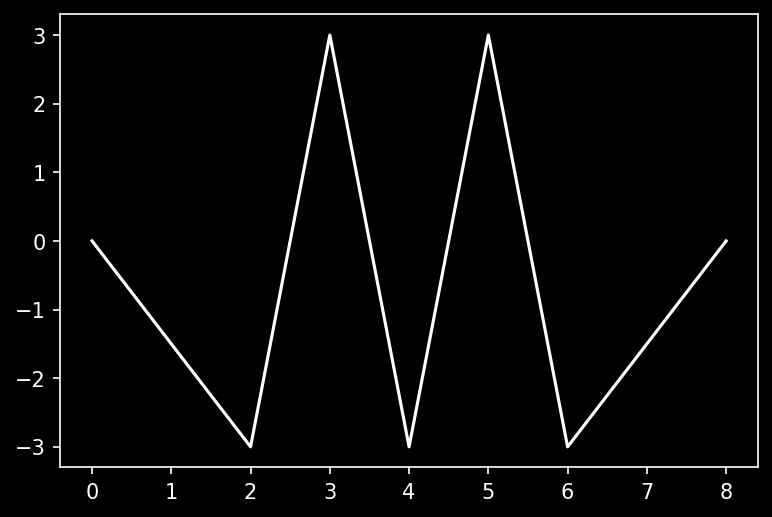

In [155]:
vector_data = """
PULS4S:
	VEC 2,-3
	VEC 1,6
	VEC 1,-6
	VEC 1,6
	VEC 1,-6
	VEC 2,3
"""
vectors = parse_vector_commands(vector_data,default_color="white")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


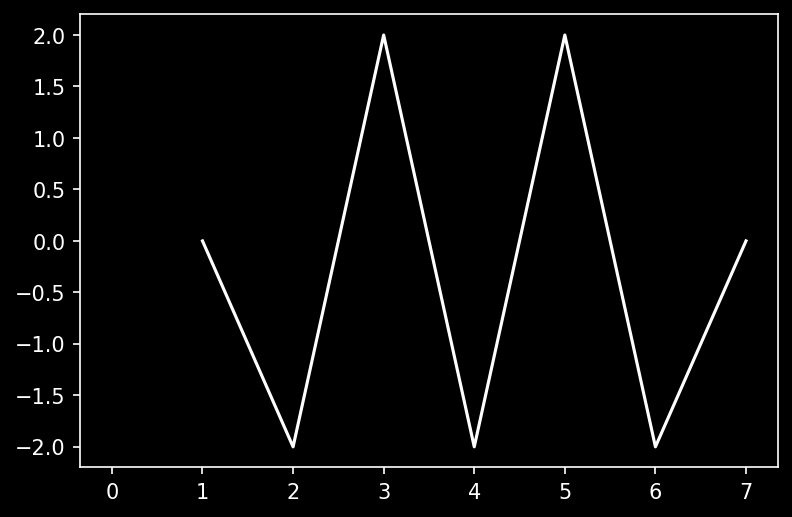

In [156]:
vector_data = """
PULS3S:
	VEC 1,0,0
	VEC 1,-2
	VEC 1,4
	VEC 1,-4
	VEC 1,4
	VEC 1,-4
	VEC 1,2
"""
vectors = parse_vector_commands(vector_data,default_color="white")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


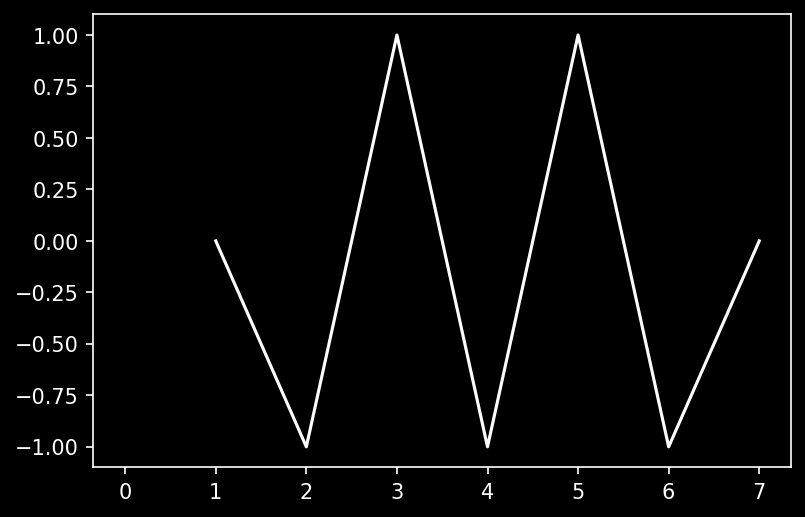

In [157]:
vector_data = """
PULS2S:
	VEC 1,0,0
	VEC 1,-1
	VEC 1,2
	VEC 1,-2
	VEC 1,2
	VEC 1,-2
	VEC 1,1
"""
vectors = parse_vector_commands(vector_data,default_color="white")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


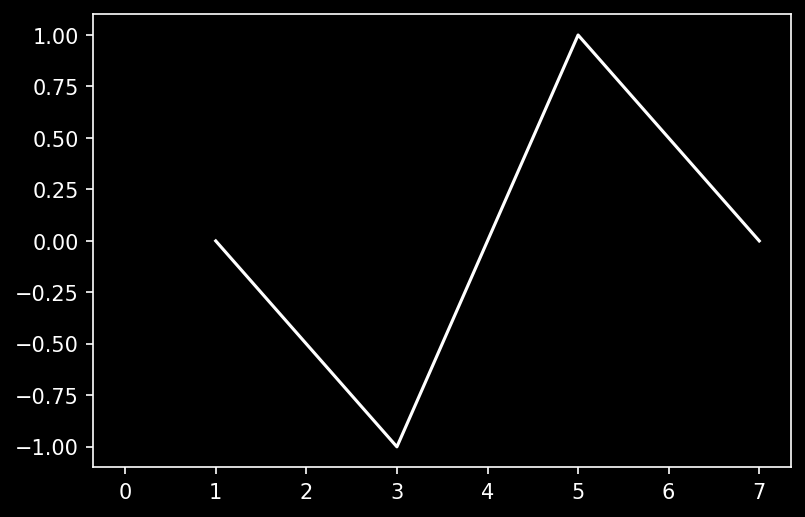

In [158]:
vector_data = """
PULS1S:
	VEC 1,0,0
	VEC 2,-1
	VEC 2,2
	VEC 2,-1
"""
vectors = parse_vector_commands(vector_data,default_color="white")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


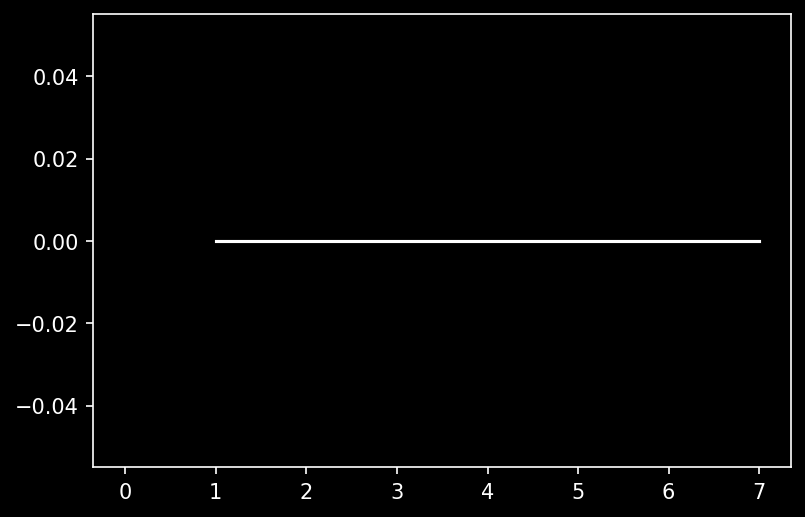

In [159]:
vector_data = """
PULS0S:	
    VEC 1,0,0
	VEC 6,0
"""
vectors = parse_vector_commands(vector_data,default_color="white")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


## Images from ALVROM.MAC

These are all the other images used by the game, including title text. We start with an interesting find: unused prototypes for the player's claw!

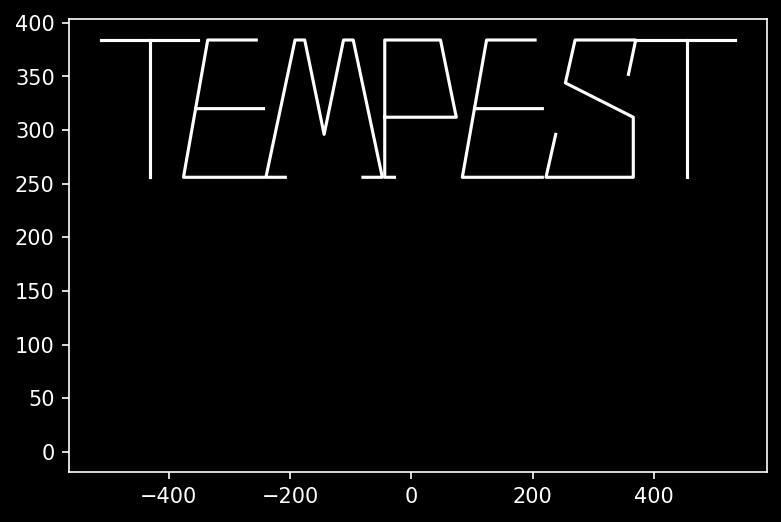

In [160]:
vector_data = """
TEMLIT:
	CNTR
	VCTR -1B0,100,0
T:	
    VCTR 0,80,CB		;T
	VCTR -50,0,0
	VCTR 0A0,0,CB
	RTSL
	VCTR 60,0,0
E:	
    VCTR -50,0,CB		;E
	VCTR -14,-40,CB
	VCTR 70,0,CB
	VCTR -70,0,0
	VCTR -14,-40,CB
	VCTR 84,0,CB
	RTSL
	VCTR 24,0,0
M:	
    VCTR -20,0,CB		;M
	VCTR 30,80,CB
	VCTR 10,0,CB
	VCTR 20,-58,CB
	VCTR 20,58,CB
	VCTR 10,0,CB
	VCTR 30,-80,CB
	VCTR -20,0,CB
	RTSL
	VCTR 34,0,0
P:	
    VCTR -10,0,CB		;P
	VCTR 0,80,CB
	VCTR 5C,0,CB
	VCTR 1A,-48,CB
	VCTR -76,0,CB
	RTSL
	VCTR 0F8,48,0
E:	
    VCTR -50,0,CB		;E
	VCTR -14,-40,CB
	VCTR 70,0,CB
	VCTR -70,0,0
	VCTR -14,-40,CB
	VCTR 84,0,CB
	RTSL
	VCTR 16,28,0
S:	
    VCTR -10,-28,CB		;S
	VCTR 90,0,CB
	VCTR 0,38,CB
	VCTR -70,20,CB
	VCTR 10,28,CB
	VCTR 64,0,CB
	VCTR -0C,-20,CB
	RTSL
	VCTR 60,-60,0
T:	
    VCTR 0,80,CB		;T
	VCTR -50,0,0
	VCTR 0A0,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


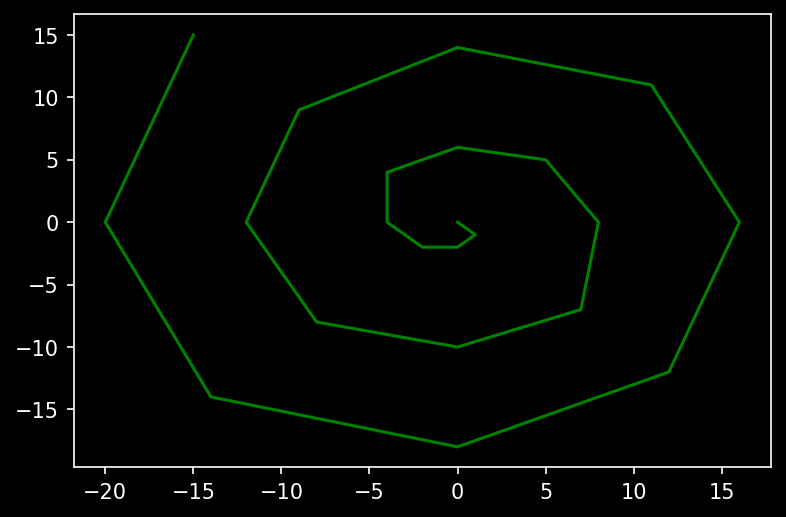

In [161]:
vector_data = """
SPIRA1:
	CSTAT GREEN
	ICVEC
	SCVEC 1,-1,CB
	SCVEC 0,-2,CB
	SCVEC -2,-2,CB
	SCVEC -4,0,CB
	SCVEC -4,4,CB
	SCVEC 0,6,CB
	SCVEC 5,5,CB
	SCVEC 8,0,CB
	SCVEC 7,-7,CB
	SCVEC 0,-0A,CB
	SCVEC -8,-8,CB
	SCVEC -0C,0,CB
	SCVEC -9,9,CB
	SCVEC 0,0E,CB
	SCVEC 0B,0B,CB
	SCVEC 10,0,CB
	SCVEC 0C,-0C,CB
	SCVEC 0,-12,CB
	SCVEC -0E,-0E,CB
	SCVEC -14,0,CB
	SCVEC -0F,0F,CB
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


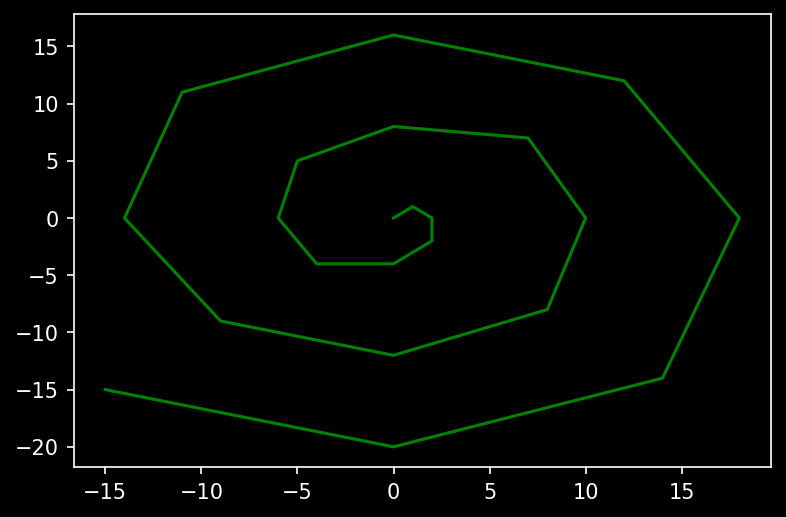

In [162]:
vector_data = """
SPIRA2:
	CSTAT GREEN
	ICVEC
	SCVEC 1,1,CB
	SCVEC 2,0,CB
	SCVEC 2,-2,CB
	SCVEC 0,-4,CB
	SCVEC -4,-4,CB
	SCVEC -6,0,CB
	SCVEC -5,5,CB
	SCVEC 0,8,CB
	SCVEC 7,7,CB
	SCVEC 0A,0,CB
	SCVEC 8,-8,CB
	SCVEC 0,-0C,CB
	SCVEC -9,-9,CB
	SCVEC -0E,0,CB
	SCVEC -0B,0B,CB
	SCVEC 0,10,CB
	SCVEC 0C,0C,CB
	SCVEC 12,0,CB
	SCVEC 0E,-0E,CB
	SCVEC 0,-14,CB
	SCVEC -0F,-0F,CB
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


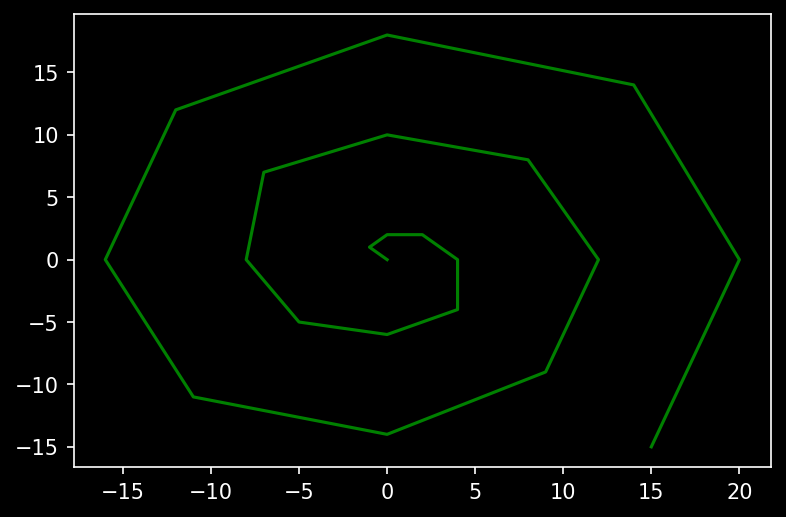

In [163]:
vector_data = """
SPIRA3:
	CSTAT GREEN
	ICVEC
	SCVEC -1,1,CB
	SCVEC 0,2,CB
	SCVEC 2,2,CB
	SCVEC 4,0,CB
	SCVEC 4,-4,CB
	SCVEC 0,-6,CB
	SCVEC -5,-5,CB
	SCVEC -8,0,CB
	SCVEC -7,7,CB
	SCVEC 0,0A,CB
	SCVEC 8,8,CB
	SCVEC 0C,0,CB
	SCVEC 9,-9,CB
	SCVEC 0,-0E,CB
	SCVEC -0B,-0B,CB
	SCVEC -10,0,CB
	SCVEC -0C,0C,CB
	SCVEC 0,12,CB
	SCVEC 0E,0E,CB
	SCVEC 14,0,CB
	SCVEC 0F,-0F,CB
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


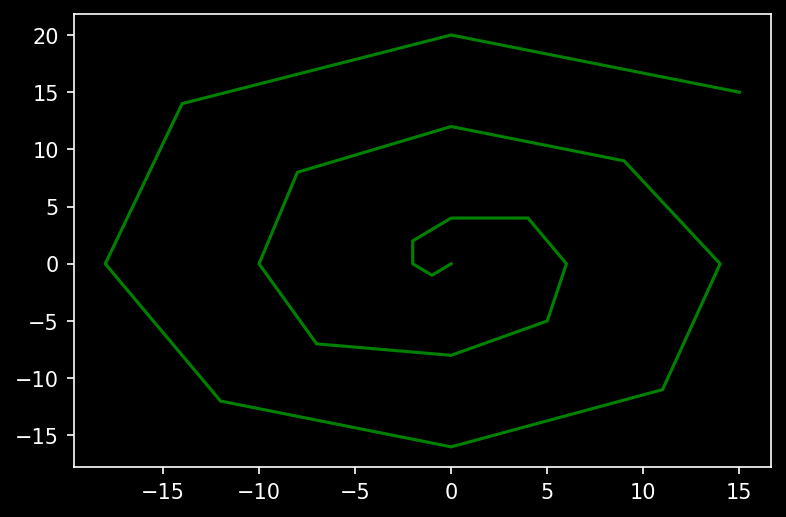

In [164]:
vector_data = """
SPIRA4:
	CSTAT GREEN
	ICVEC
	SCVEC -1,-1,CB
	SCVEC -2,0,CB
	SCVEC -2,2,CB
	SCVEC 0,4,CB
	SCVEC 4,4,CB
	SCVEC 6,0,CB
	SCVEC 5,-5,CB
	SCVEC 0,-8,CB
	SCVEC -7,-7,CB
	SCVEC -0A,0,CB
	SCVEC -8,8,CB
	SCVEC 0,0C,CB
	SCVEC 9,9,CB
	SCVEC 0E,0,CB
	SCVEC 0B,-0B,CB
	SCVEC 0,-10,CB
	SCVEC -0C,-0C,CB
	SCVEC -12,0,CB
	SCVEC -0E,0E,CB
	SCVEC 0,14,CB
	SCVEC 0F,0F,CB
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


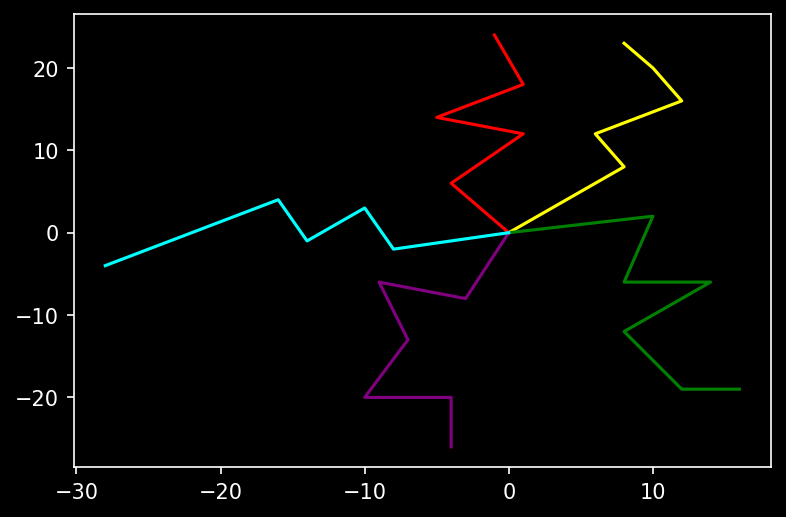

In [165]:
vector_data = """
FUSE0:	
    ICVEC
	CSTAT RED
	SCVEC -4,6,CB
	SCVEC 1,0C,CB
	SCVEC -5,0E,CB
	SCVEC 1,12,CB
	SCVEC -1,18,CB
	CSTAT YELLOW
	SCVEC 8,17,0
	SCVEC 0A,14,CB
	SCVEC 0C,10,CB
	SCVEC 6,0C,CB
	SCVEC 8,8,CB
	SCVEC 0,0,CB
	CSTAT GREEN
	SCVEC 0A,2,CB
	SCVEC 8,-6,CB
	SCVEC 0E,-6,CB
	SCVEC 8,-0C,CB
	SCVEC 0C,-13,CB
	SCVEC 10,-13,CB
	CSTAT PURPLE
	SCVEC -4,-1A,0
	SCVEC -4,-14,CB
	SCVEC -0A,-14,CB
	SCVEC -7,-0D,CB
	SCVEC -9,-6,CB
	SCVEC -3,-8,CB
	SCVEC 0,0,CB
	CSTAT TURQOI
	SCVEC -8,-2,CB
	SCVEC -0A,3,CB
	SCVEC -0E,-1,CB
	SCVEC -10,4,CB
	SCVEC -1C,-4,CB
"""

vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


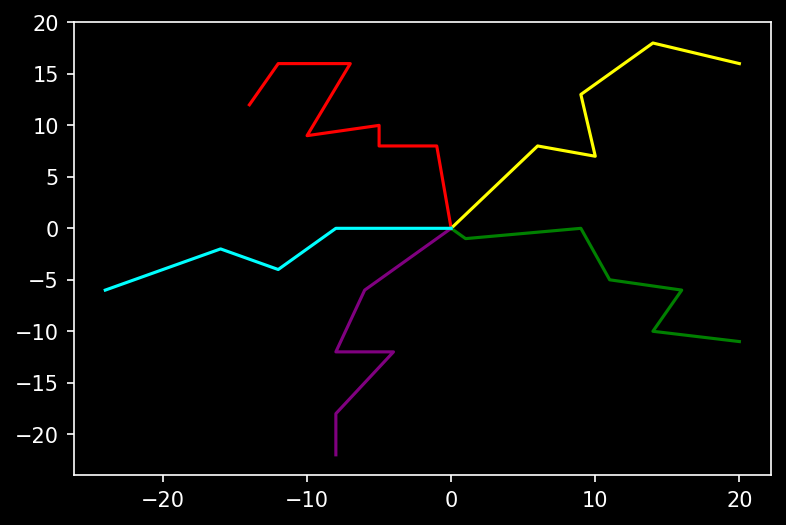

In [166]:
vector_data = """
FUSE1:	
    ICVEC
	CSTAT RED
	SCVEC -1,8,CB
	SCVEC -5,8,CB
	SCVEC -5,0A,CB
	SCVEC -0A,9,CB
	SCVEC -7,10,CB
	SCVEC -0C,10,CB
	SCVEC -0E,0C,CB
	CSTAT YELLOW
	SCVEC 14,10,0
	SCVEC 0E,12,CB
	SCVEC 9,0D,CB
	SCVEC 0A,7,CB
	SCVEC 6,8,CB
	SCVEC 0,0,CB
	CSTAT GREEN
	SCVEC 1,-1,CB
	SCVEC 9,0,CB
	SCVEC 0B,-5,CB
	SCVEC 10,-6,CB
	SCVEC 0E,-0A,CB
	SCVEC 14,-0B,CB
	CSTAT PURPLE
	SCVEC -8,-16,0
	SCVEC -8,-12,CB
	SCVEC -4,-0C,CB
	SCVEC -8,-0C,CB
	SCVEC -6,-6,CB
	SCVEC 0,0,CB
	CSTAT TURQOI
	SCVEC -8,0,CB
	SCVEC -0C,-4,CB
	SCVEC -10,-2,CB
	SCVEC -18,-6,CB
"""

vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


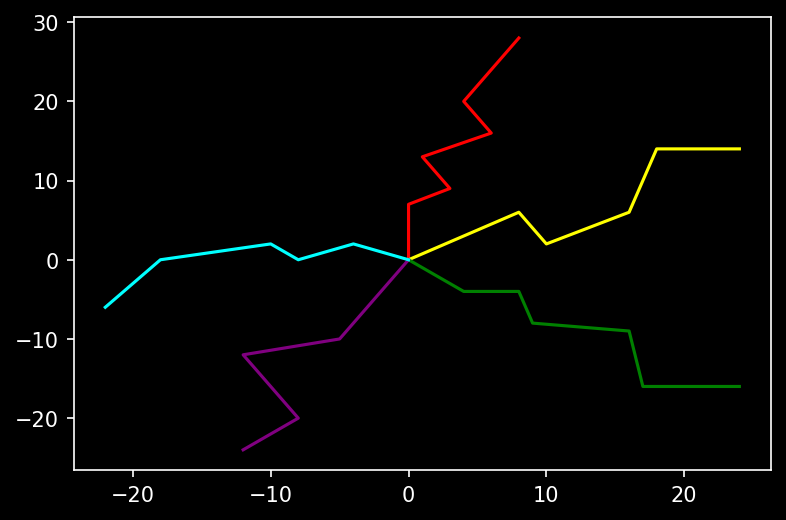

In [167]:
vector_data = """
FUSE2:
	ICVEC
	CSTAT RED
	SCVEC 0,7,CB
	SCVEC 3,9,CB
	SCVEC 1,0D,CB
	SCVEC 6,10,CB
	SCVEC 4,14,CB
	SCVEC 8,1C,CB
	CSTAT YELLOW
	SCVEC 18,0E,0
	SCVEC 12,0E,CB
	SCVEC 10,6,CB
	SCVEC 0A,2,CB
	SCVEC 8,6,CB
	SCVEC 0,0,CB
	CSTAT GREEN
	SCVEC 4,-4,CB
	SCVEC 8,-4,CB
	SCVEC 9,-8,CB
	SCVEC 10,-9,CB
	SCVEC 11,-10,CB
	SCVEC 18,-10,CB
	CSTAT PURPLE
	SCVEC -0C,-18,0
	SCVEC -8,-14,CB
	SCVEC -0C,-0C,CB
	SCVEC -5,-0A,CB
	SCVEC 0,0,CB
	CSTAT TURQOI
	SCVEC -4,2,CB
	SCVEC -8,0,CB
	SCVEC -0A,2,CB
	SCVEC -12,0,CB
	SCVEC -16,-6,CB
"""

vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


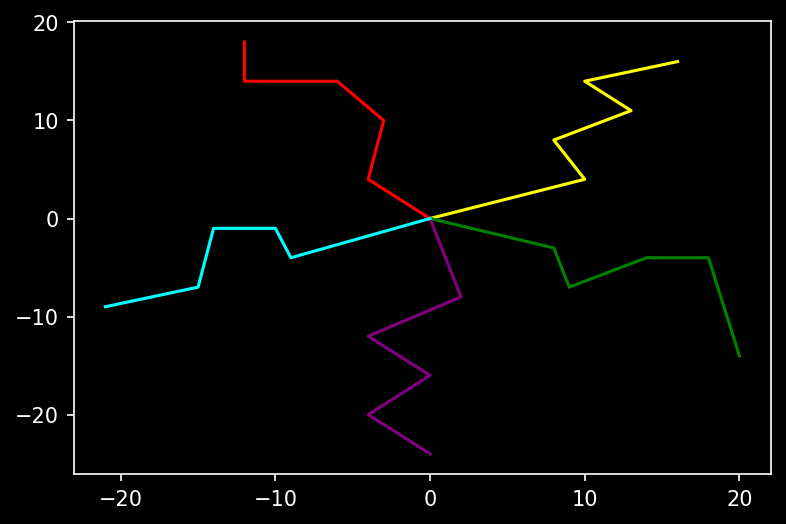

In [168]:
vector_data = """
FUSE3:	
    ICVEC
	CSTAT RED
	SCVEC -4,4,CB
	SCVEC -3,0A,CB
	SCVEC -6,0E,CB
	SCVEC -0C,0E,CB
	SCVEC -0C,12,CB
	CSTAT YELLOW
	SCVEC 10,10,0
	SCVEC 0A,0E,CB
	SCVEC 0D,0B,CB
	SCVEC 8,8,CB
	SCVEC 0A,4,CB
	SCVEC 0,0,CB
	CSTAT GREEN
	SCVEC 8,-3,CB
	SCVEC 9,-7,CB
	SCVEC 0E,-4,CB
	SCVEC 12,-4,CB
	SCVEC 14,-0E,CB
	CSTAT PURPLE
	SCVEC 0,-18,0
	SCVEC -4,-14,CB
	SCVEC 0,-10,CB
	SCVEC -4,-0C,CB
	SCVEC 2,-8,CB
	SCVEC 0,0,CB
	CSTAT TURQOI
	SCVEC -9,-4,CB
	SCVEC -0A,-1,CB
	SCVEC -0E,-1,CB
	SCVEC -0F,-7,CB
	SCVEC -15,-9,CB
"""

vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


Flipper/enemy explosion

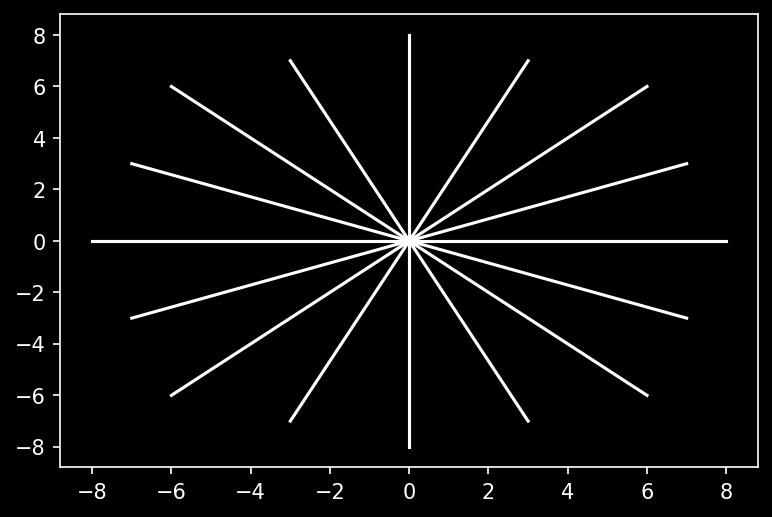

In [169]:
vector_data = """
EXPL1:
	CSTAT WHITE
	ICVEC
	SPOK16			;16 SPOKES 1 SCALE FULL INTENSITY
	.MACRO SPOK16		;INPUT: CM=SCALE MULTIPLIER
				;       CB=INTENSITY
				;       CD=SCALE DIVIDER
	ICVEC
	SCVEC 7,3
	SCVEC -7,-3,CB
	SCVEC -6,-6
	SCVEC 6,6,CB
	SCVEC 3,7
	SCVEC -3,-7,CB
	SCVEC 0,-8
	SCVEC 0,8,CB
	SCVEC -3,7
	SCVEC 3,-7,CB
	SCVEC 6,-6
	SCVEC -6,6,CB
	SCVEC -7,3
	SCVEC 7,-3,CB
	SCVEC 8,0
	SCVEC -8,0,CB
	SCVEC 0,0
"""

vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


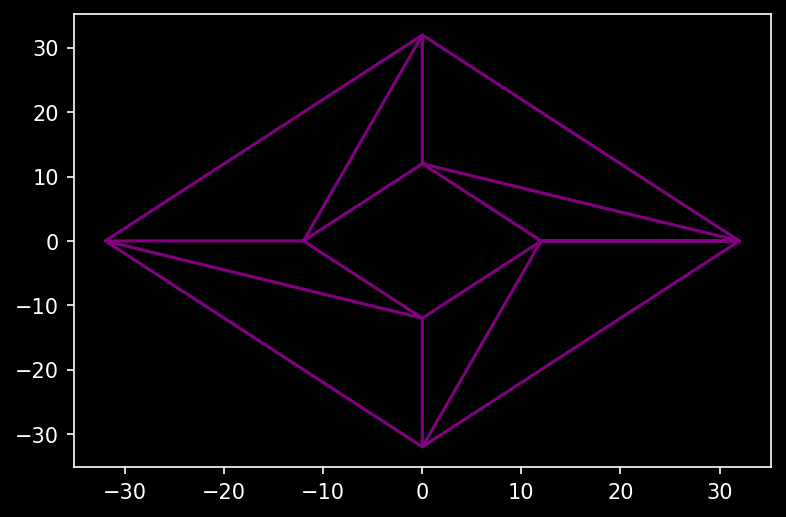

In [170]:

vector_data = """
TANKR:
	ICVEC
    CSTAT PURPLE
	SCVEC 20,0,0
GENTNK:	
	SCVEC 0,20,CB
	SCVEC 0,0C,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	SCVEC 0,0C,CB
	SCVEC -0C,0,CB
	SCVEC 0,20,CB
	SCVEC -20,0,CB
	SCVEC -0C,0,CB
	SCVEC 0,-0C,CB
	SCVEC -20,0,CB
	SCVEC 0,-20,CB
	SCVEC 0,-0C,CB
	SCVEC 0C,0,CB
	SCVEC 0,-20,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


I had never noticed that the tankers containing pulsars and fuses have a little badge on the front indicating their contents!

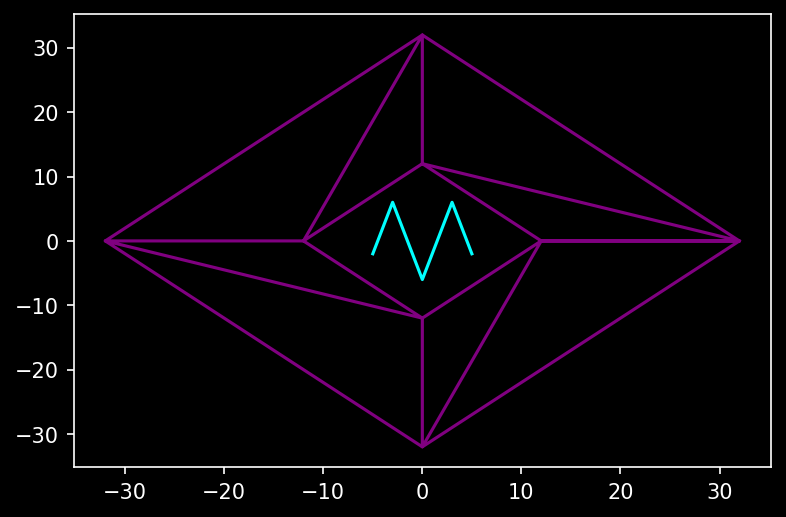

In [171]:
vector_data = """
TANKP:			;TANKER OF PULSARS
	ICVEC
	CSTAT TURQOI
	SCVEC -5,-2,0
	SCVEC -3,6,CB
	SCVEC 0,-6,CB
	SCVEC 3,6,CB
	SCVEC 5,-2,CB
	SCVEC 20,0,0
	JMPL GENTNK
GENTNK:	
    CSTAT PURPLE
	SCVEC 0,20,CB
	SCVEC 0,0C,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	SCVEC 0,0C,CB
	SCVEC -0C,0,CB
	SCVEC 0,20,CB
	SCVEC -20,0,CB
	SCVEC -0C,0,CB
	SCVEC 0,-0C,CB
	SCVEC -20,0,CB
	SCVEC 0,-20,CB
	SCVEC 0,-0C,CB
	SCVEC 0C,0,CB
	SCVEC 0,-20,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


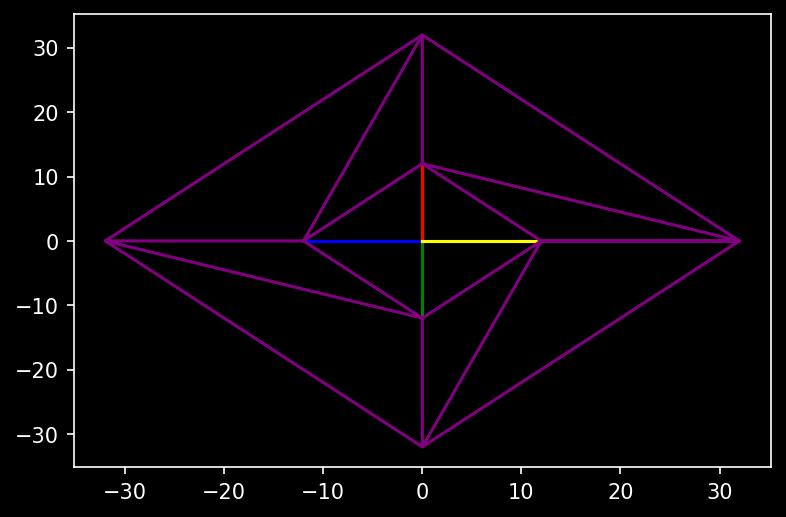

In [172]:
vector_data = """
TANKF:				;TANKER OF FUSES
	ICVEC
	CSTAT BLUE
	SCVEC -0C,0,CB
	SCVEC 0,0C,0
	CSTAT RED
	SCVEC 0,0,CB
	CSTAT GREEN
	SCVEC 0,-0C,CB
	SCVEC 0,0,0
	CSTAT YELLOW
	SCVEC 0C,0,CB
	SCVEC 20,0,0
GENTNK:	
    CSTAT PURPLE
	SCVEC 0,20,CB
	SCVEC 0,0C,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	SCVEC 0,0C,CB
	SCVEC -0C,0,CB
	SCVEC 0,20,CB
	SCVEC -20,0,CB
	SCVEC -0C,0,CB
	SCVEC 0,-0C,CB
	SCVEC -20,0,CB
	SCVEC 0,-20,CB
	SCVEC 0,-0C,CB
	SCVEC 0C,0,CB
	SCVEC 0,-20,CB
	SCVEC 20,0,CB
	SCVEC 0C,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


[(0, 0, 'BLACK'), (8, 0, 'BLACK'), (-1, 3, 'WHITE'), (-1, 3, 'WHITE'), (-3, 1, 'WHITE'), (-3, 1, 'WHITE'), (-3, -1, 'WHITE'), (-3, -1, 'WHITE'), (-1, -3, 'WHITE'), (-1, -3, 'WHITE'), (1, -3, 'WHITE'), (1, -3, 'WHITE'), (3, -1, 'WHITE'), (3, -1, 'WHITE'), (3, 1, 'WHITE'), (3, 1, 'WHITE'), (1, 3, 'WHITE'), (1, 3, 'WHITE'), (-8, 0, 'BLACK')]
[(0, 0, 'BLACK'), (8, 0, 'BLACK'), (8, 0, 'WHITE'), (7, 3, 'WHITE'), (6, 6, 'WHITE'), (3, 7, 'WHITE'), (0, 8, 'WHITE'), (-3, 7, 'WHITE'), (-6, 6, 'WHITE'), (-7, 3, 'WHITE'), (-8, 0, 'WHITE'), (-7, -3, 'WHITE'), (-6, -6, 'WHITE'), (-3, -7, 'WHITE'), (0, -8, 'WHITE'), (3, -7, 'WHITE'), (6, -6, 'WHITE'), (7, -3, 'WHITE'), (8, 0, 'WHITE'), (8, 0, 'BLACK'), (0, 0, 'BLACK')]


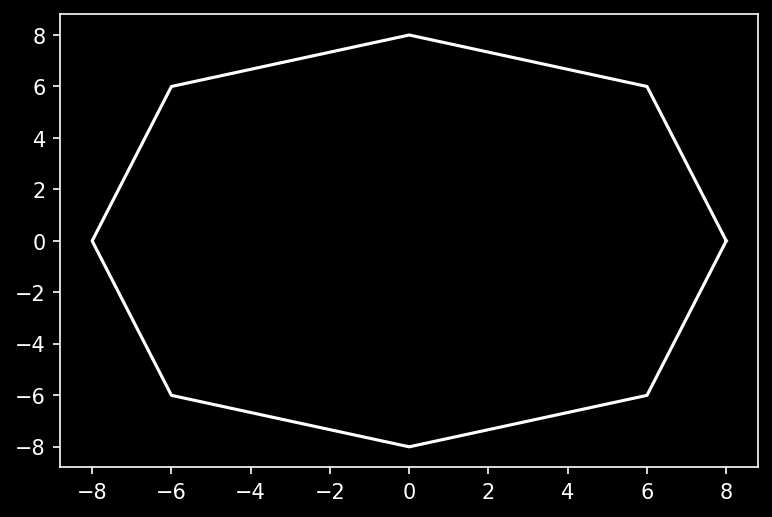

In [173]:
vector_data = """
	ICVEC
	SCVEC 8,0,0
	SCVEC 7,3,CB
	SCVEC 6,6,CB
	SCVEC 3,7,CB
	SCVEC 0,8,CB
	SCVEC -3,7,CB
	SCVEC -6,6,CB
	SCVEC -7,3,CB
	SCVEC -8,0,CB
	SCVEC -7,-3,CB
	SCVEC -6,-6,CB
	SCVEC -3,-7,CB
	SCVEC 0,-8,CB
	SCVEC 3,-7,CB
	SCVEC 6,-6,CB
	SCVEC 7,-3,CB
	SCVEC 8,0,CB
	SCVEC 0,0
	RTSL
"""
vectors = parse_vector_commands(vector_data)
print(vectors)
vertices = vectors_to_coords(vectors)
print(vertices)
plot_vertices(vertices)


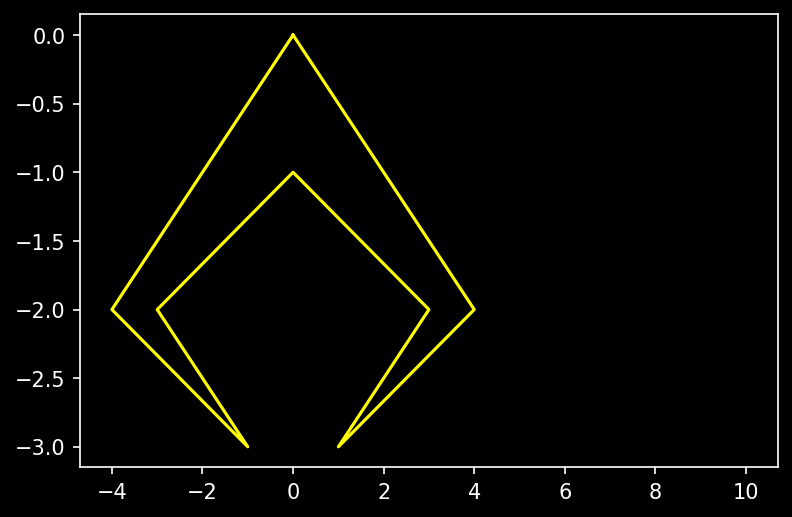

In [174]:
vector_data = """
LIFEY:
	CSTAT YELLOW
LIFE1:	
    ICVEC
	SCVEC 4,-2,CB
	SCVEC 1,-3,CB
	SCVEC 3,-2,CB
	SCVEC 0,-1,CB
	SCVEC -3,-2,CB
	SCVEC -1,-3,CB
	SCVEC -4,-2,CB
	SCVEC 0,0,CB
LIFE0:	
    SCVEC 0A,0,0
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


[(0, 0, 'BLACK'), (-17, 17, 'BLACK'), (-6, 6, 'WHITE'), (0, -40, 'BLACK'), (6, -6, 'WHITE'), (40, 0, 'BLACK'), (-6, 6, 'WHITE'), (0, 40, 'BLACK'), (6, -6, 'WHITE'), (-17, -11, 'BLACK'), (0, 0, 'RED'), (-12, 0, 'BLACK'), (0, 0, 'RED'), (0, -12, 'BLACK'), (0, 0, 'RED'), (12, 0, 'BLACK'), (0, 0, 'RED')]
[(0, 0, 'BLACK'), (-17, 17, 'BLACK'), (-17, 17, 'WHITE'), (-23, 23, 'WHITE'), (-23, 23, 'BLACK'), (-23, -17, 'BLACK'), (-23, -17, 'WHITE'), (-17, -23, 'WHITE'), (-17, -23, 'BLACK'), (23, -23, 'BLACK'), (23, -23, 'WHITE'), (17, -17, 'WHITE'), (17, -17, 'BLACK'), (17, 23, 'BLACK'), (17, 23, 'WHITE'), (23, 17, 'WHITE'), (23, 17, 'BLACK'), (6, 6, 'BLACK'), (6, 6, 'RED'), (6, 6, 'RED'), (6, 6, 'BLACK'), (-6, 6, 'BLACK'), (-6, 6, 'RED'), (-6, 6, 'RED'), (-6, 6, 'BLACK'), (-6, -6, 'BLACK'), (-6, -6, 'RED'), (-6, -6, 'RED'), (-6, -6, 'BLACK'), (6, -6, 'BLACK'), (6, -6, 'RED'), (6, -6, 'RED')]


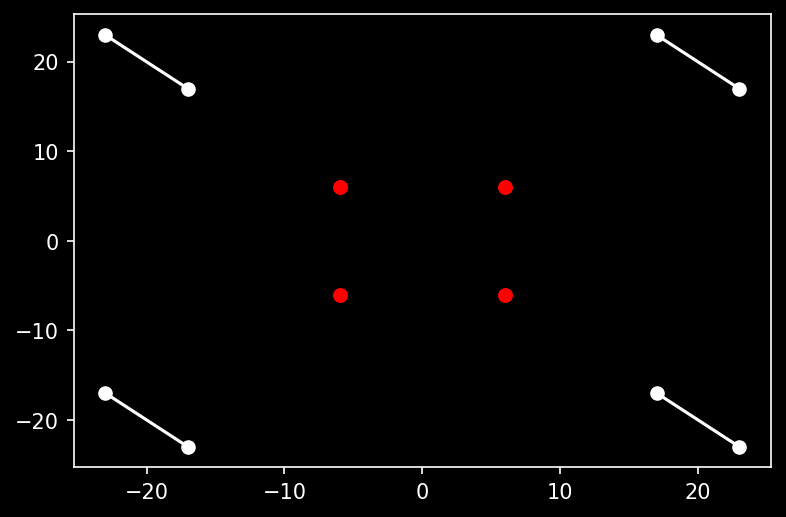

In [175]:
vector_data = """
	ICVEC
	CSTAT WHITE
	SCVEC -11.,11.,0
	SCVEC -17.,17.,CB
	SCVEC -17.,-11.,0
	SCVEC -11.,-17.,CB
	SCVEC 17.,-17.,0
	SCVEC 11.,-11.,CB
	SCVEC 11.,17.,0
	SCVEC 17.,11.,CB
	SCVEC 6,6,0
	CSTAT RED
	VCTR 0,0,CB
	SCVEC -6,6,0
	VCTR 0,0,CB
	SCVEC -6,-6,0
	VCTR 0,0,CB
	SCVEC 6,-6,0
	VCTR 0,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
print(vectors)
vertices = vectors_to_coords(vectors)
print(vertices)
plot_vertices(vertices,"o")


[(0, 0, 'BLACK'), (-24, 18, 'BLACK'), (0, -14, 'WHITE'), (16, -24, 'BLACK'), (0, -14, 'WHITE'), (32, 16, 'BLACK'), (0, 14, 'WHITE'), (-16, 24, 'BLACK'), (0, 14, 'WHITE'), (-11, -27, 'BLACK'), (0, 0, 'RED'), (-4, -4, 'BLACK'), (0, 0, 'RED'), (10, -10, 'BLACK'), (0, 0, 'RED'), (4, 10, 'BLACK'), (0, 0, 'RED')]
[(0, 0, 'BLACK'), (-24, 18, 'BLACK'), (-24, 18, 'WHITE'), (-24, 4, 'WHITE'), (-24, 4, 'BLACK'), (-8, -20, 'BLACK'), (-8, -20, 'WHITE'), (-8, -34, 'WHITE'), (-8, -34, 'BLACK'), (24, -18, 'BLACK'), (24, -18, 'WHITE'), (24, -4, 'WHITE'), (24, -4, 'BLACK'), (8, 20, 'BLACK'), (8, 20, 'WHITE'), (8, 34, 'WHITE'), (8, 34, 'BLACK'), (-3, 7, 'BLACK'), (-3, 7, 'RED'), (-3, 7, 'RED'), (-3, 7, 'BLACK'), (-7, 3, 'BLACK'), (-7, 3, 'RED'), (-7, 3, 'RED'), (-7, 3, 'BLACK'), (3, -7, 'BLACK'), (3, -7, 'RED'), (3, -7, 'RED'), (3, -7, 'BLACK'), (7, 3, 'BLACK'), (7, 3, 'RED'), (7, 3, 'RED')]


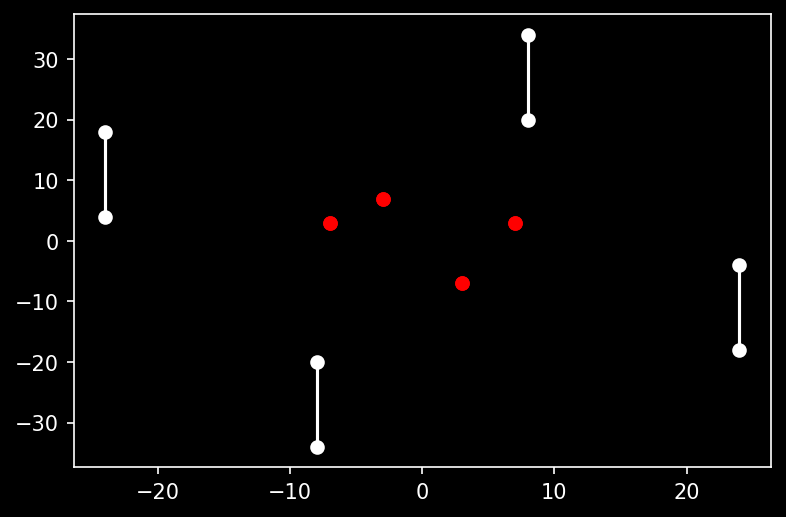

In [176]:
vector_data = """
ESHOT2:
	ICVEC
	CSTAT WHITE
	SCVEC -18.,12,0
	SCVEC -18.,4,CB
	SCVEC -8,-14.,0
	SCVEC -8,-22.,CB
	SCVEC 18.,-12.,0
	SCVEC 18.,-4,CB
	SCVEC 8,14.,0
	SCVEC 8,22.,CB
	SCVEC -3,7,0
	CSTAT RED
	VCTR 0,0,CB
	SCVEC -7,3,0
	VCTR 0,0,CB
	SCVEC 3,-7,0
	VCTR 0,0,CB
	SCVEC 7,3,0
	VCTR 0,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
print(vectors)
vertices = vectors_to_coords(vectors)
print(vertices)
plot_vertices(vertices,"o")


[(0, 0, 'BLACK'), (-23, 3, 'BLACK'), (-12, -6, 'WHITE'), (32, -32, 'BLACK'), (6, 12, 'WHITE'), (20, 20, 'BLACK'), (12, 6, 'WHITE'), (-32, 32, 'BLACK'), (-6, -12, 'WHITE'), (3, -15, 'BLACK'), (0, 0, 'RED'), (-8, -8, 'BLACK'), (0, 0, 'RED'), (8, -8, 'BLACK'), (0, 0, 'RED'), (8, 8, 'BLACK'), (0, 0, 'RED')]
[(0, 0, 'BLACK'), (-23, 3, 'BLACK'), (-23, 3, 'WHITE'), (-35, -3, 'WHITE'), (-35, -3, 'BLACK'), (-3, -35, 'BLACK'), (-3, -35, 'WHITE'), (3, -23, 'WHITE'), (3, -23, 'BLACK'), (23, -3, 'BLACK'), (23, -3, 'WHITE'), (35, 3, 'WHITE'), (35, 3, 'BLACK'), (3, 35, 'BLACK'), (3, 35, 'WHITE'), (-3, 23, 'WHITE'), (-3, 23, 'BLACK'), (0, 8, 'BLACK'), (0, 8, 'RED'), (0, 8, 'RED'), (0, 8, 'BLACK'), (-8, 0, 'BLACK'), (-8, 0, 'RED'), (-8, 0, 'RED'), (-8, 0, 'BLACK'), (0, -8, 'BLACK'), (0, -8, 'RED'), (0, -8, 'RED'), (0, -8, 'BLACK'), (8, 0, 'BLACK'), (8, 0, 'RED'), (8, 0, 'RED')]


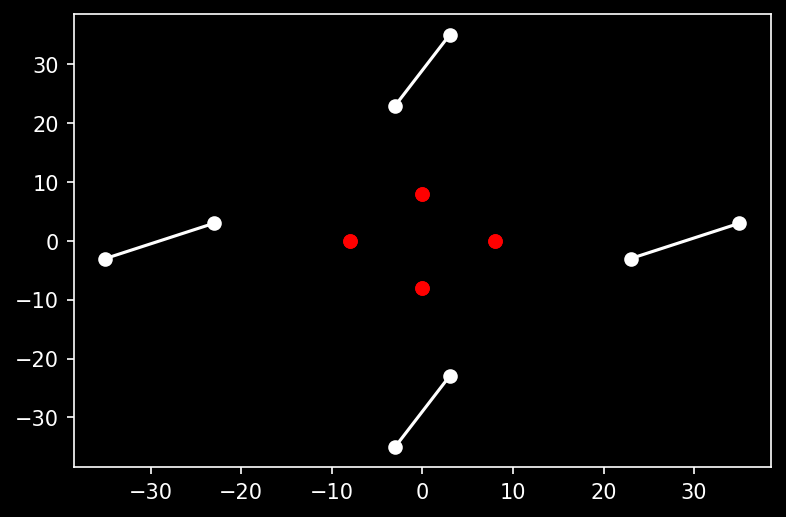

In [177]:
vector_data = """
ESHOT3:
	ICVEC
	CSTAT WHITE
	SCVEC -17.,3,0
	SCVEC -23.,-3,CB
	SCVEC -3,-23.,0
	SCVEC 3,-17.,CB
	SCVEC 17.,-3,0
	SCVEC 23.,3,CB
	SCVEC 3,23.,0
	SCVEC -3,17,CB
	SCVEC 0,8,0
	CSTAT RED
	VCTR 0,0,CB
	SCVEC -8,0,0
	VCTR 0,0,CB
	SCVEC 0,-8,0
	VCTR 0,0,CB
	SCVEC 8,0,0
	VCTR 0,0,CB
	RTSL
"""
vectors = parse_vector_commands(vector_data)
print(vectors)
vertices = vectors_to_coords(vectors)
print(vertices)
plot_vertices(vertices,"o")


[(0, 0, 'BLACK'), (-34, -8, 'BLACK'), (14, 0, 'WHITE'), (24, -16, 'BLACK'), (14, 0, 'WHITE'), (2, 32, 'BLACK'), (14, 0, 'WHITE'), (-38, 16, 'BLACK'), (-14, 0, 'WHITE'), (11, -21, 'BLACK'), (0, 0, 'RED'), (4, -10, 'BLACK'), (0, 0, 'RED'), (10, 10, 'BLACK'), (0, 0, 'RED'), (-4, 4, 'BLACK')]
[(0, 0, 'BLACK'), (-34, -8, 'BLACK'), (-34, -8, 'WHITE'), (-20, -8, 'WHITE'), (-20, -8, 'BLACK'), (4, -24, 'BLACK'), (4, -24, 'WHITE'), (18, -24, 'WHITE'), (18, -24, 'BLACK'), (20, 8, 'BLACK'), (20, 8, 'WHITE'), (34, 8, 'WHITE'), (34, 8, 'BLACK'), (-4, 24, 'BLACK'), (-4, 24, 'WHITE'), (-18, 24, 'WHITE'), (-18, 24, 'BLACK'), (-7, 3, 'BLACK'), (-7, 3, 'RED'), (-7, 3, 'RED'), (-7, 3, 'BLACK'), (-3, -7, 'BLACK'), (-3, -7, 'RED'), (-3, -7, 'RED'), (-3, -7, 'BLACK'), (7, 3, 'BLACK'), (7, 3, 'RED'), (7, 3, 'RED'), (7, 3, 'BLACK'), (3, 7, 'BLACK')]


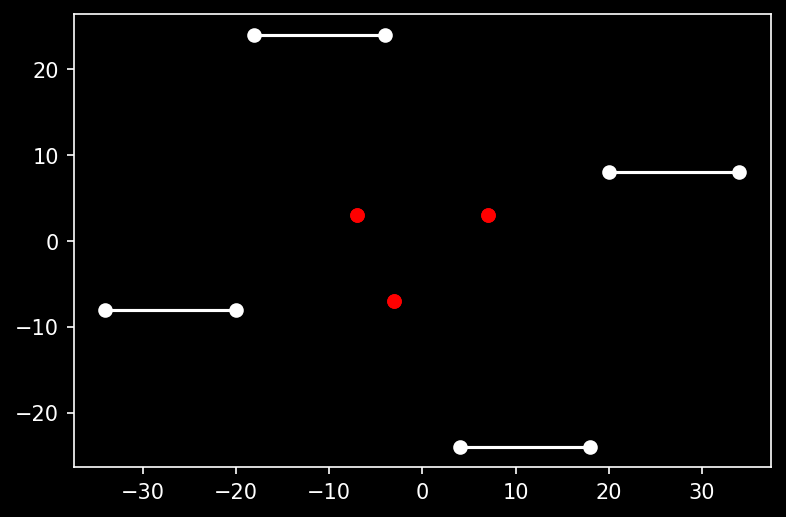

In [178]:
vector_data = """
ESHOT4:
	ICVEC
	CSTAT WHITE
	SCVEC -22.,-8,0
	SCVEC -14.,-8,CB
	SCVEC 4,-18.,0
	SCVEC 12.,-18.,CB
	SCVEC 14.,8,0
	SCVEC 22.,8,CB
	SCVEC -4,18.,0
	SCVEC -12.,18.,CB
	SCVEC -7,3,0
	CSTAT RED
	VCTR 0,0,CB
	SCVEC -3,-7,0
	VCTR 0,0,CB
	SCVEC 7,3,0
	VCTR 0,0,CB
	SCVEC 3,7,0
"""
vectors = parse_vector_commands(vector_data)
print(vectors)
vertices = vectors_to_coords(vectors)
print(vertices)
plot_vertices(vertices,"o")


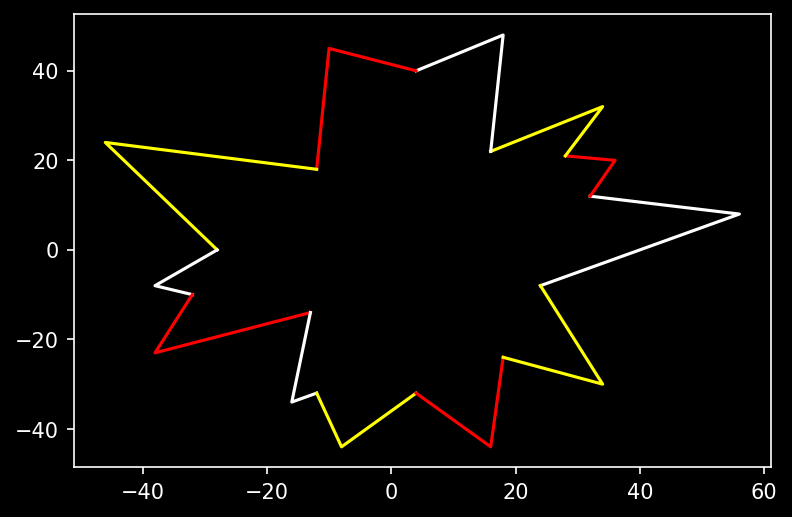

In [179]:
vector_data = """
SPLAT:
	ICVEC
	CSTAT PDIWHI
	SCVEC 18,-8,0
	SCVEC 38,8,CB
	SCVEC 20,0C,CB
	CSTAT PDIRED
	SCVEC 24,14,CB
	SCVEC 1C,15,CB
	CSTAT PDIYEL
	SCVEC 22,20,CB
	SCVEC 10,16,CB
	CSTAT PDIWHI
	SCVEC 12,30,CB
	SCVEC 4,28,CB
	CSTAT PDIRED
	SCVEC -0A,2D,CB
	SCVEC -0C,12,CB
	CSTAT PDIYEL
	SCVEC -2E,18,CB
	SCVEC -1C,0,CB
	CSTAT PDIWHI
	SCVEC -26,-8,CB
	SCVEC -20,-0A,CB
	CSTAT PDIRED
	SCVEC -26,-17,CB
	SCVEC -0D,-0E,CB
	CSTAT PDIWHI
	SCVEC -10,-22,CB
	SCVEC -0C,-20,CB
	CSTAT PDIYEL
	SCVEC -8,-2C,CB
	SCVEC 4,-20,CB
	CSTAT PDIRED
	SCVEC 10,-2C,CB
	SCVEC 12,-18,CB
	CSTAT PDIYEL
	SCVEC 22,-1E,CB
	SCVEC 18,-8,CB
	SCVEC 0,0,0
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


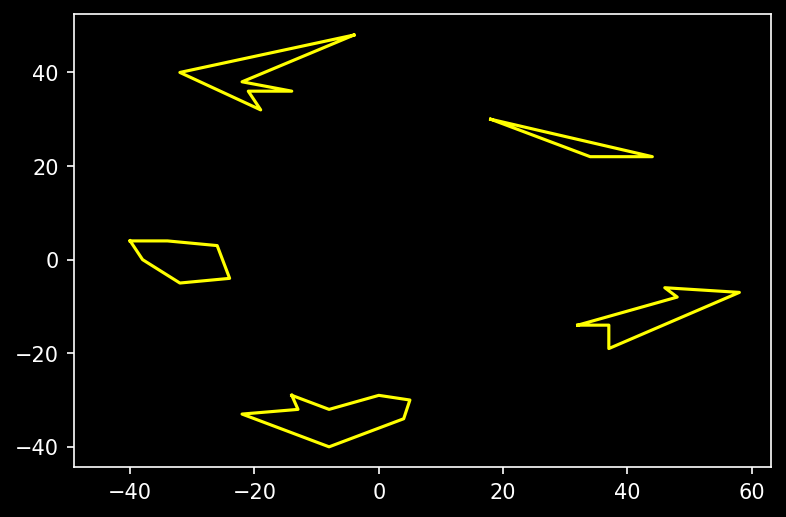

In [180]:
vector_data = """
SHRAP:
	ICVEC
	JSRL SCALE		;SCALE FOR POSITION OF PIECE 1
	SCVEC 20,-0E,0		;POSITION FOR PIECE 1
	SCAL 1,0		;SCALE FOR PIECE 1
	CSTAT YELLOW
	SCVEC 25,-0E,CB	;PIECE 1
	SCVEC 25,-13,CB
	SCVEC 3A,-7,CB
	SCVEC 2E,-6,CB
	SCVEC 30,-8,CB
	SCVEC 20,-0E,CB
	JSRL SCALE		;SHOT 1
	SCVEC 10,6,0
	JSRL JADOT
	JSRL SCALE		;PIECE 2
	SCVEC 12,1E,0
	SCAL 1,0
	CSTAT YELLOW
	SCVEC 22,16,CB
	SCVEC 2C,16,CB
	SCVEC 12,1E,CB
	JSRL SCALE		;SHOT 2
	SCVEC 10,30,0
	JSRL JADOT
	JSRL SCALE		;PIECE 3
	SCVEC -4,30,0
	SCAL 1,0
	CSTAT YELLOW
	SCVEC -20,28,CB
	SCVEC -13,20,CB
	SCVEC -15,24,CB
	SCVEC -0E,24,CB
	SCVEC -16,26,CB
	SCVEC -4,30,CB
	JSRL SCALE		;SHOT 3
	SCVEC -0C,10,0
	JSRL JADOT
	JSRL SCALE		;SHOT 4
	SCVEC -2C,18,0
	JSRL JADOT
	JSRL SCALE		;PIECE 4
	SCVEC -28,4,0
	SCAL 1,0
	CSTAT YELLOW
	SCVEC -26,0,CB
	SCVEC -20,-5,CB
	SCVEC -18,-4,CB
	SCVEC -1A,3,CB
	SCVEC -22,4,CB
	SCVEC -28,4,CB
	JSRL SCALE		;SHOT 1
	SCVEC -0C,-0C,0
	JSRL JADOT
	JSRL SCALE		;PIECE 5
	SCVEC -0E,-1D,0
	SCAL 1,0
	CSTAT YELLOW
	SCVEC -0D,-20,CB
	SCVEC -16,-21,CB
	SCVEC -8,-28,CB
	SCVEC 4,-22,CB
	SCVEC 5,-1E,CB
	SCVEC 0,-1D,CB
	SCVEC -8,-20,CB
	SCVEC -0E,-1D,CB
	JSRL SCALE		;SHOT 2
	SCVEC 18,-24,0
	JMPL JADOT
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


[(0, 0, 'BLACK'), (0, 0, 'BLACK'), (0, 0, 'WHITE'), (7, 0, 'BLACK'), (0, 0, 'WHITE'), (-2, 5, 'BLACK'), (0, 0, 'WHITE'), (-5, 2, 'BLACK'), (0, 0, 'WHITE'), (-5, -2, 'BLACK'), (0, 0, 'WHITE'), (-2, -5, 'BLACK'), (0, 0, 'WHITE'), (2, -5, 'BLACK'), (0, 0, 'WHITE'), (5, -2, 'BLACK'), (0, 0, 'WHITE'), (5, 2, 'BLACK'), (0, 0, 'WHITE'), (10, 5, 'BLACK'), (0, 0, 'YELLOW'), (-4, 11, 'BLACK'), (0, 0, 'YELLOW'), (-11, 4, 'BLACK'), (0, 0, 'YELLOW'), (-11, -4, 'BLACK'), (0, 0, 'YELLOW'), (0, -11, 'BLACK'), (0, 0, 'YELLOW'), (0, -11, 'BLACK'), (0, 0, 'YELLOW'), (11, 0, 'BLACK'), (0, 0, 'YELLOW'), (11, 0, 'BLACK'), (0, 0, 'YELLOW')]


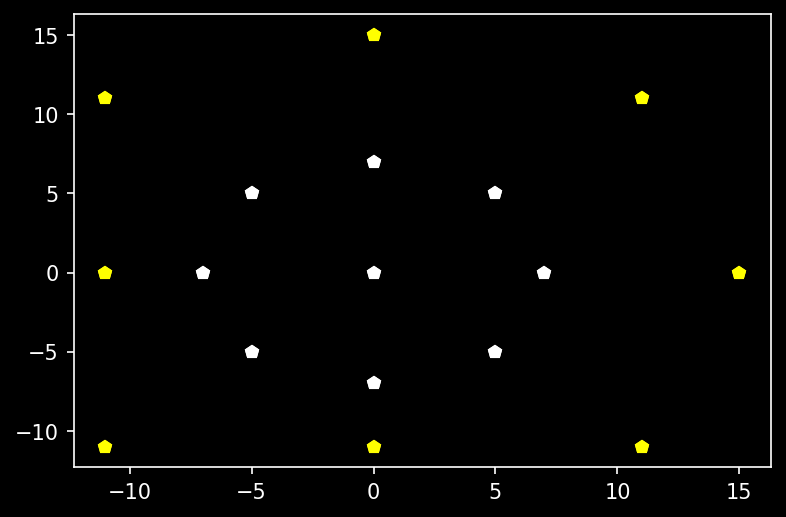

In [181]:
vector_data = """
DIARA2:	
    ICVEC
	CSTAT WHITE
	SCDOT 0,0
	SCDOT 7,0
	SCDOT 5,5
	SCDOT 0,7
	SCDOT -5,5
	SCDOT -7,0
	SCDOT -5,-5
	SCDOT 0,-7
	SCDOT 5,-5
	CSTAT YELLOW
	SCDOT 0F,0
	SCDOT 0B,0B
	SCDOT 0,0F
	SCDOT -0B,0B
	SCDOT -0B,0
	SCDOT -0B,-0B
	SCDOT 0,-0B
	SCDOT 0B,-0B
	RTSL
"""
vectors = parse_vector_commands(vector_data,default_color="red")
print(vectors)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


[(0, 0, 'BLACK'), (-8, 0, 'BLACK'), (0, 0, 'WHITE'), (16, 12, 'BLACK'), (0, 0, 'WHITE'), (8, -12, 'BLACK'), (0, 0, 'WHITE'), (-8, 48, 'BLACK'), (0, 0, 'WHITE'), (-56, -16, 'BLACK'), (0, 0, 'WHITE'), (-4, -64, 'BLACK'), (0, 0, 'WHITE'), (44, -40, 'BLACK'), (0, 0, 'WHITE'), (80, 40, 'BLACK'), (0, 0, 'WHITE'), (-4, 72, 'BLACK'), (0, 0, 'WHITE'), (-44, 40, 'BLACK'), (0, 0, 'WHITE'), (-80, -12, 'BLACK'), (0, 0, 'WHITE'), (-16, -76, 'BLACK'), (0, 0, 'WHITE'), (8, -72, 'BLACK'), (0, 0, 'WHITE'), (80, -32, 'BLACK'), (0, 0, 'WHITE'), (72, 32, 'BLACK'), (0, 0, 'WHITE'), (16, 72, 'BLACK'), (0, 0, 'WHITE'), (-16, 88, 'BLACK'), (0, 0, 'WHITE'), (-80, 32, 'BLACK'), (0, 0, 'WHITE'), (-72, -8, 'BLACK'), (0, 0, 'WHITE'), (-56, -64, 'BLACK'), (0, 0, 'WHITE'), (8, -80, 'BLACK'), (0, 0, 'WHITE'), (0, -64, 'BLACK'), (0, 0, 'WHITE'), (112, 104, 'BLACK')]


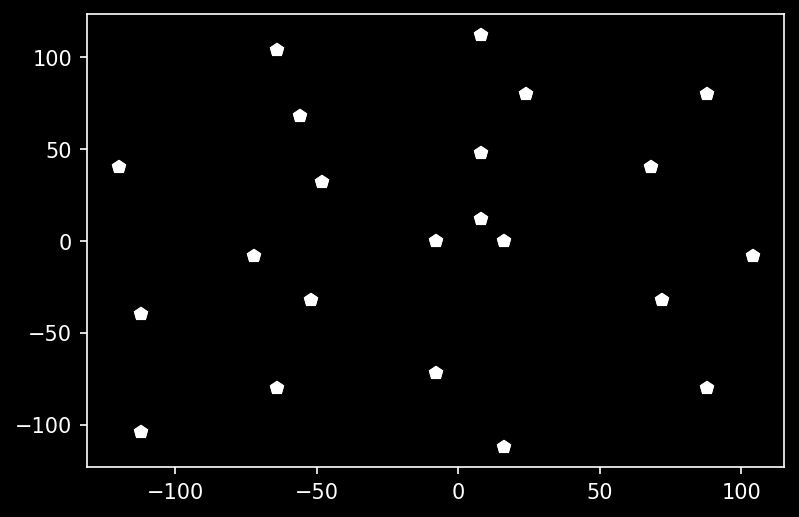

In [182]:
vector_data = """
.MACRO MSTAR1
	ICVEC
	SCDOT -8,0
	SCDOT 8,0C
	SCDOT 10,0
	SCDOT 8,30
	SCDOT -30,20
	SCDOT -34,-20
	SCDOT -8,-48
	SCDOT 48,-20
	SCDOT 44,28
	SCDOT 18,50
	SCDOT -38,44
	SCDOT -48,-8
	SCDOT -40,-50
	SCDOT 10,-70
	SCDOT 58,-50
	SCDOT 68,-8
	SCDOT 58,50
	SCDOT 8,70
	SCDOT -40,68
	SCDOT -78,28
	SCDOT -70,-28
	SCDOT -70,-68
	SCVEC 0,0,0
	RTSL
"""
vectors = parse_vector_commands(vector_data,default_color="red")
print(vectors)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


[(0, 0, 'BLACK'), (8, 8, 'BLACK'), (0, 0, 'WHITE'), (-16, 8, 'BLACK'), (0, 0, 'WHITE'), (-16, -32, 'BLACK'), (0, 0, 'WHITE'), (32, -24, 'BLACK'), (0, 0, 'WHITE'), (32, 32, 'BLACK'), (0, 0, 'WHITE'), (-8, 40, 'BLACK'), (0, 0, 'WHITE'), (-24, 24, 'BLACK'), (0, 0, 'WHITE'), (-40, -8, 'BLACK'), (0, 0, 'WHITE'), (-32, -40, 'BLACK'), (0, 0, 'WHITE'), (24, -72, 'BLACK'), (0, 0, 'WHITE'), (92, -4, 'BLACK'), (0, 0, 'WHITE'), (36, 92, 'BLACK'), (0, 0, 'WHITE'), (-32, 56, 'BLACK'), (0, 0, 'WHITE'), (-72, 24, 'BLACK'), (0, 0, 'WHITE'), (-72, -64, 'BLACK'), (0, 0, 'WHITE'), (0, -88, 'BLACK'), (0, 0, 'WHITE'), (32, -56, 'BLACK'), (0, 0, 'WHITE'), (56, -16, 'BLACK'), (0, 0, 'WHITE'), (96, 16, 'BLACK'), (0, 0, 'WHITE'), (8, 56, 'BLACK'), (0, 0, 'WHITE')]


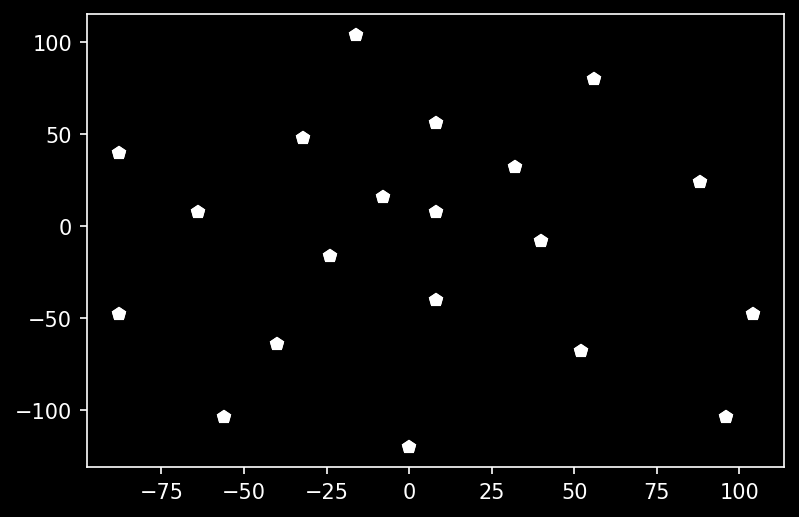

In [183]:
vector_data = """
.MACRO MSTAR2
	ICVEC
	SCDOT 8,8
	SCDOT -8,10
	SCDOT -18,-10
	SCDOT 8,-28
	SCDOT 28,-8
	SCDOT 20,20
	SCDOT 8,38
	SCDOT -20,30
	SCDOT -40,8
	SCDOT -28,-40
	SCDOT 34,-44
	SCDOT 58,18
	SCDOT 38,50
	SCDOT -10,68
	SCDOT -58,28
	SCDOT -58,-30
	SCDOT -38,-68
	SCDOT 0,-78
	SCDOT 60,-68
	SCDOT 68,-30
	RTSL
"""
vectors = parse_vector_commands(vector_data,default_color="red")
print(vectors)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


[(0, 0, 'BLACK'), (16, 16, 'BLACK'), (0, 0, 'WHITE'), (-16, 8, 'BLACK'), (0, 0, 'WHITE'), (-48, -16, 'BLACK'), (0, 0, 'WHITE'), (24, -52, 'BLACK'), (0, 0, 'WHITE'), (64, 20, 'BLACK'), (0, 0, 'WHITE'), (8, 32, 'BLACK'), (0, 0, 'WHITE'), (8, 48, 'BLACK'), (0, 0, 'WHITE'), (-56, 16, 'BLACK'), (0, 0, 'WHITE'), (-56, -32, 'BLACK'), (0, 0, 'WHITE'), (-8, -48, 'BLACK'), (0, 0, 'WHITE'), (32, -80, 'BLACK'), (0, 0, 'WHITE'), (64, 0, 'BLACK'), (0, 0, 'WHITE'), (48, 40, 'BLACK'), (0, 0, 'WHITE'), (16, 80, 'BLACK'), (0, 0, 'WHITE'), (-52, 68, 'BLACK'), (0, 0, 'WHITE'), (-76, 4, 'BLACK'), (0, 0, 'WHITE'), (-68, -48, 'BLACK'), (0, 0, 'WHITE'), (-4, -64, 'BLACK'), (0, 0, 'WHITE'), (8, -64, 'BLACK'), (0, 0, 'WHITE'), (56, -48, 'BLACK'), (0, 0, 'WHITE'), (104, 0, 'BLACK'), (0, 0, 'WHITE')]


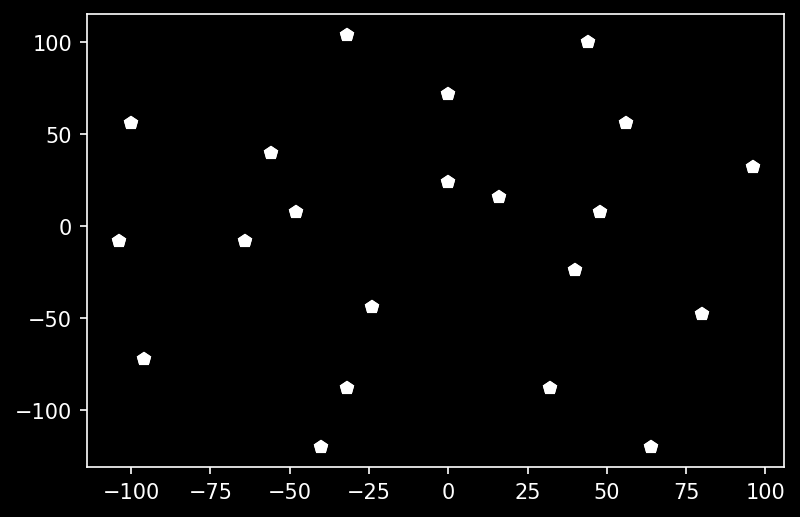

In [184]:
vector_data = """
.MACRO MSTAR3
	ICVEC
	SCDOT 10,10
	SCDOT 0,18
	SCDOT -30,8
	SCDOT -18,-2C
	SCDOT 28,-18
	SCDOT 30,8
	SCDOT 38,38
	SCDOT 0,48
	SCDOT -38,28
	SCDOT -40,-8
	SCDOT -20,-58
	SCDOT 20,-58
	SCDOT 50,-30
	SCDOT 60,20
	SCDOT 2C,64
	SCDOT -20,68
	SCDOT -64,38
	SCDOT -68,-8
	SCDOT -60,-48
	SCDOT -28,-78
	SCDOT 40,-78
	RTSL
	.ENDM
"""
vectors = parse_vector_commands(vector_data,default_color="red")
print(vectors)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


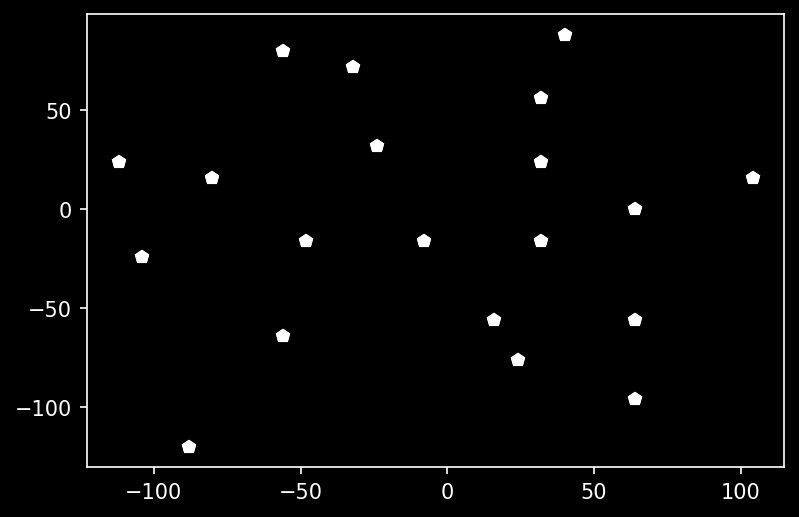

In [185]:
vector_data = """
.MACRO MSTAR4
	ICVEC
	SCDOT -8,-10
	SCDOT 20,-10
	SCDOT 20,18
	SCDOT -18,20
	SCDOT -30,-10
	SCDOT 10,-38
	SCDOT 40,0
	SCDOT 20,38
	SCDOT -20,48
	SCDOT -50,10
	SCDOT -38,-40
	SCDOT 18,-4C
	SCDOT 40,-38
	SCDOT 68,10
	SCDOT 28,58
	SCDOT -38,50
	SCDOT -70,18
	SCDOT -68,-18
	SCDOT -58,-78
	SCDOT 40,-60
	RTSL
"""
vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


## Unused Pictures in ALVROM.MAC

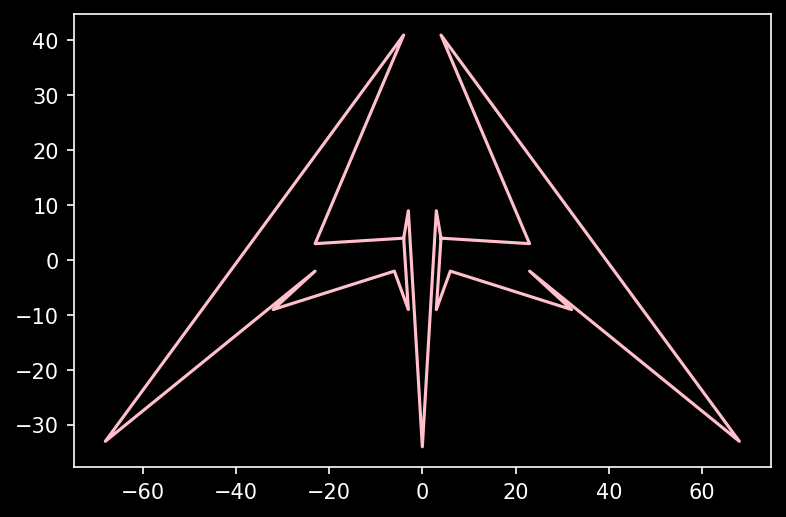

In [186]:
vector_data = """
ENER11:
	ICALVE
	CALVEC -4,4
	.BRITE=VARBRT
	CALVEC -17.,3
	CALVEC -4,29.
	CALVEC -44.,-21.
	CALVEC -17.,-2
	CALVEC -20.,-9
	CALVEC -6,-2
	CALVEC -3,-9
	CALVEC -4,4
	CALVEC -3,9
	CALVEC 0,-22.
	CALVEC 3,9
	CALVEC 4,4
	CALVEC 3,-9
	CALVEC 6,-2
	CALVEC 20.,-9
	CALVEC 17.,-2
	CALVEC 44.,-21.
	CALVEC 4,29.
	CALVEC 17.,3
	CALVEC 4,4
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="pink")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


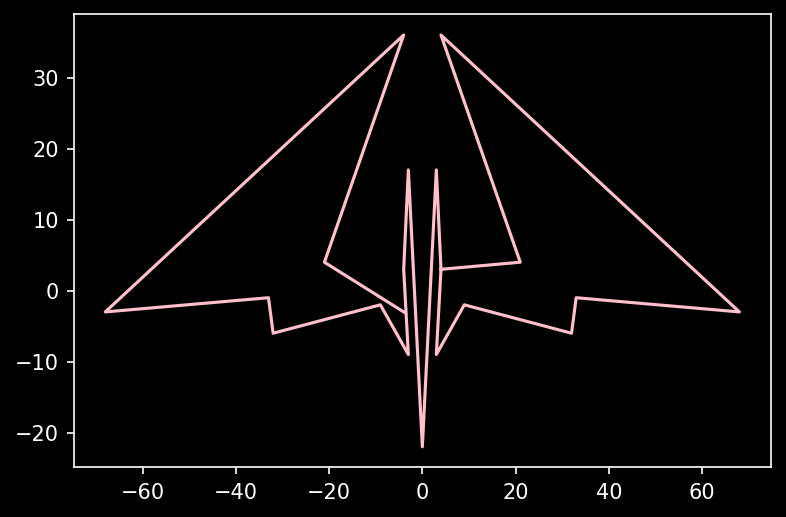

In [187]:
vector_data = """
ENER12:
	ICALVE
	CALVEC -4,-3
	.BRITE=VARBRT
	CALVEC -15.,4
	CALVEC -4,24.
	CALVEC -44.,-3
	CALVEC -21.,-1
	CALVEC -20.,-6
	CALVEC -9,-2
	CALVEC -3,-9
	CALVEC -4,3
	CALVEC -3,11.
	CALVEC 0,-16.
	CALVEC 3,11.
	CALVEC 4,3
	CALVEC 3,-9
	CALVEC 9,-2
	CALVEC 20.,-6
	CALVEC 21.,-1
	CALVEC 44.,-3
	CALVEC 4,24.
	CALVEC 15.,4
	CALVEC 4,3
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="pink")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


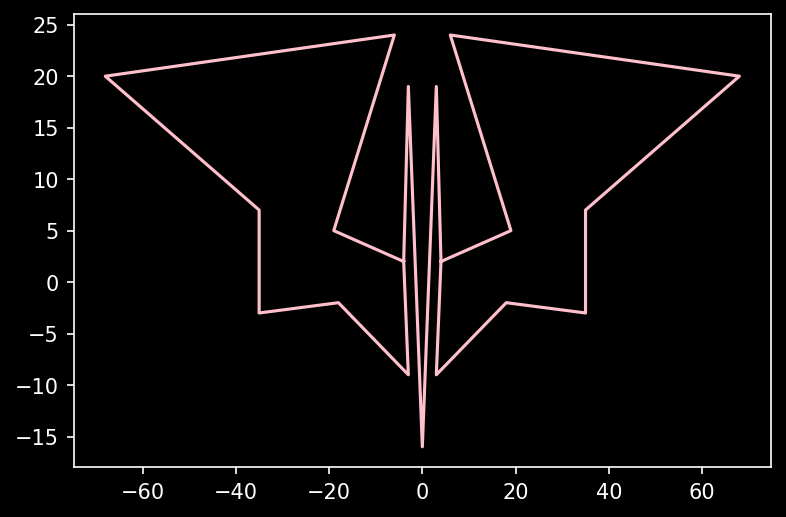

In [188]:
vector_data = """
ENER13:
	ICALVE
	CALVEC -4,2
	.BRITE=VARBRT
	CALVEC -13.,5
	CALVEC -6,18.
	CALVEC -44.,14.
	CALVEC -23.,7.
	CALVEC -23.,-3
	CALVEC -12.,-2
	CALVEC -3,-9
	CALVEC -4,2
	CALVEC -3,13.
	CALVEC 0,-10.
	CALVEC 3,13.
	CALVEC 4,2
	CALVEC 3,-9
	CALVEC 12.,-2
	CALVEC 23.,-3
	CALVEC 23.,7
	CALVEC 44.,14.
	CALVEC 6,18.
	CALVEC 13.,5
	CALVEC 4,2
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="pink")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


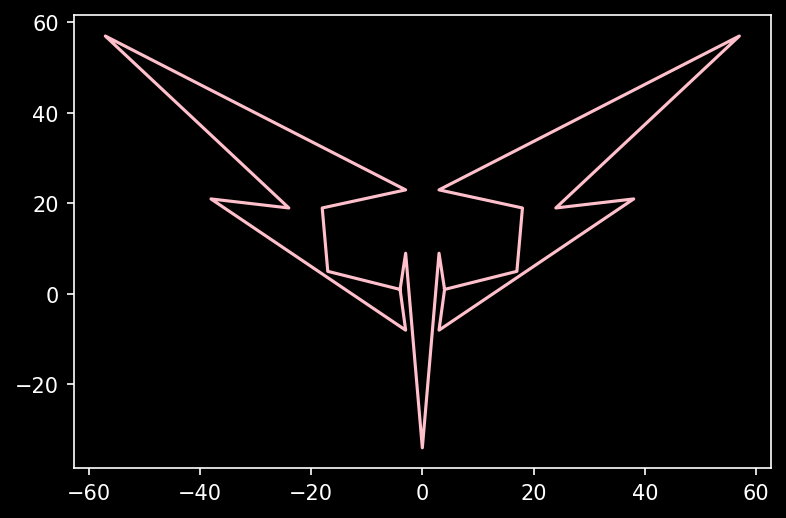

In [189]:
vector_data = """
ENER14:
	ICALVE
	CALVEC -4,1
	.BRITE=VARBRT
	CALVEC -11.,5
	CALVEC -12.,13.
	CALVEC -3,17.
	CALVEC -39.,39.
	CALVEC -18.,13.
	CALVEC -26.,15.
	CALVEC -3,-8
	CALVEC -4,1
	CALVEC -3,9
	CALVEC 0,-22.
	CALVEC 3,9
	CALVEC 4,1
	CALVEC 3,-8
	CALVEC 26.,15.
	CALVEC 18.,13.
	CALVEC 39.,39.
	CALVEC 3,17.
	CALVEC 12.,13.
	CALVEC 11.,5
	CALVEC 4,1
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="pink")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


[(0, 0, 'BLACK'), (-1, -3, 'BLACK'), (-1, -3, 'yellow'), (-4, 36, 'yellow'), (-36, 0, 'yellow'), (-18, -64, 'yellow'), (-32, -2, 'yellow'), (-21, 3, 'yellow'), (-16, -18, 'yellow'), (-18, 6, 'yellow'), (-5, 19, 'yellow'), (-3, -36, 'yellow'), (-1, -3, 'yellow'), (-1, -3, 'BLACK'), (1, -3, 'BLACK'), (1, -3, 'yellow'), (3, -36, 'yellow'), (5, 19, 'yellow'), (18, 6, 'yellow'), (16, -18, 'yellow'), (21, 3, 'yellow'), (32, -2, 'yellow'), (18, -64, 'yellow'), (36, 0, 'yellow'), (4, 36, 'yellow'), (1, -3, 'yellow'), (1, -3, 'BLACK'), (0, 0, 'BLACK')]
; X: 0  Y:0
; X: -1  Y:-3
; X: -1  Y:-3
; X: -4  Y:36
; X: -36  Y:0
; X: -18  Y:-64
; X: -32  Y:-2
; X: -21  Y:3
; X: -16  Y:-18
; X: -18  Y:6
; X: -5  Y:19
; X: -3  Y:-36
; X: -1  Y:-3
; X: -1  Y:-3
; X: 1  Y:-3
; X: 1  Y:-3
; X: 3  Y:-36
; X: 5  Y:19
; X: 18  Y:6
; X: 16  Y:-18
; X: 21  Y:3
; X: 32  Y:-2
; X: 18  Y:-64
; X: 36  Y:0
; X: 4  Y:36
; X: 1  Y:-3
; X: 1  Y:-3
; X: 0  Y:0


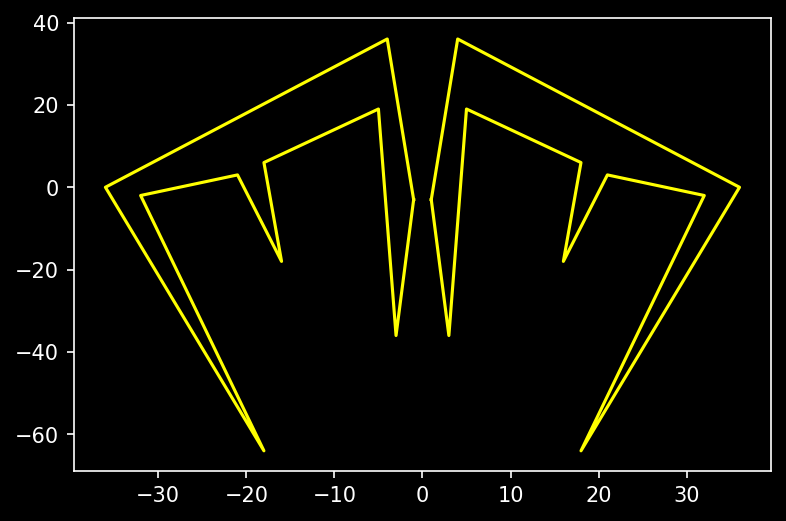

In [119]:
vector_data = """
ENER21:
	ICALVE
	CALVEC -1,-3
	.BRITE=VARBRT
	CALVEC -4,24.
	CALVEC -24.,0
	CALVEC -12.,-40.
	CALVEC -20.,-2
	CALVEC -15.,3
	CALVEC -10.,-12.
	CALVEC -12.,6
	CALVEC -5,13.
	CALVEC -3,-24.
	CALVEC -1,-3
	.BRITE=0
	CALVEC 1,-3
	.BRITE=VARBRT
	CALVEC 3,-24.
	CALVEC 5,13.
	CALVEC 12.,6
	CALVEC 10.,-12.
	CALVEC 15.,3
	CALVEC 20.,-2
	CALVEC 12.,-40.
	CALVEC 24.,0
	CALVEC 4,24.
	CALVEC 1,-3
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)
print(vertices)
for x,y,_ in vertices:
    print(f"; X: {x}  Y:{y}")


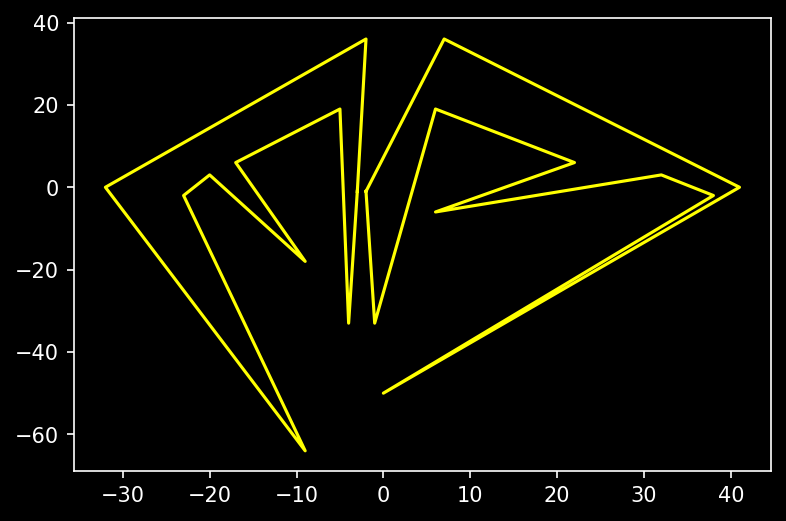

In [120]:
vector_data = """
ENER22:
	ICALVE
	CALVEC -3,-1
	.BRITE=VARBRT
	CALVEC -2,24.
	CALVEC -20.,0
	CALVEC -9,-40.
	CALVEC -17.,-2
	CALVEC -14.,3
	CALVEC -9,-12.
	CALVEC -11.,6
	CALVEC -5,13.
	CALVEC -4,-21.
	CALVEC -3,-1
	.BRITE=0
	CALVEC -2,-1
	.BRITE=VARBRT
	CALVEC 7,24.
	CALVEC 29.,0
	CALVEC 0,-32.
	CALVEC 26.,-2
	CALVEC 20.,3
	CALVEC 6,-6
	CALVEC 16.,6
	CALVEC 6,13.
	CALVEC -1,-21.
	CALVEC -2,-1
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


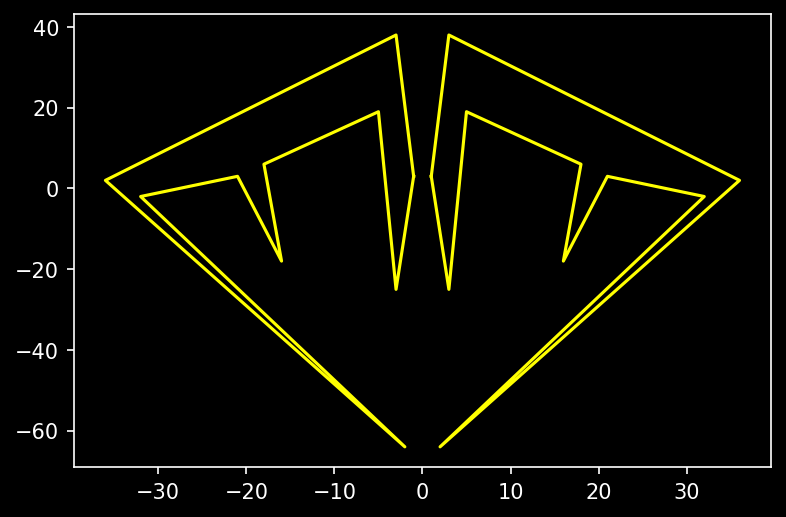

In [121]:
vector_data = """
ENER23:
    ICALVE
	CALVEC -1,3
	.BRITE=VARBRT
	CALVEC -3,26.
	CALVEC -24.,2
	CALVEC -2,-40.
	CALVEC -20.,-2
	CALVEC -15.,3
	CALVEC -10.,-12.
	CALVEC -12.,6
	CALVEC -5,13.
	CALVEC -3,-19.
	CALVEC -1,3
	.BRITE=0
	CALVEC 1,3
	.BRITE=VARBRT
	CALVEC 3,-19.
	CALVEC 5,13.
	CALVEC 12.,6
	CALVEC 10.,-12.
	CALVEC 15.,3
	CALVEC 20.,-2
	CALVEC 2,-40.
	CALVEC 24.,2
	CALVEC 3,26.
	CALVEC 1,3
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


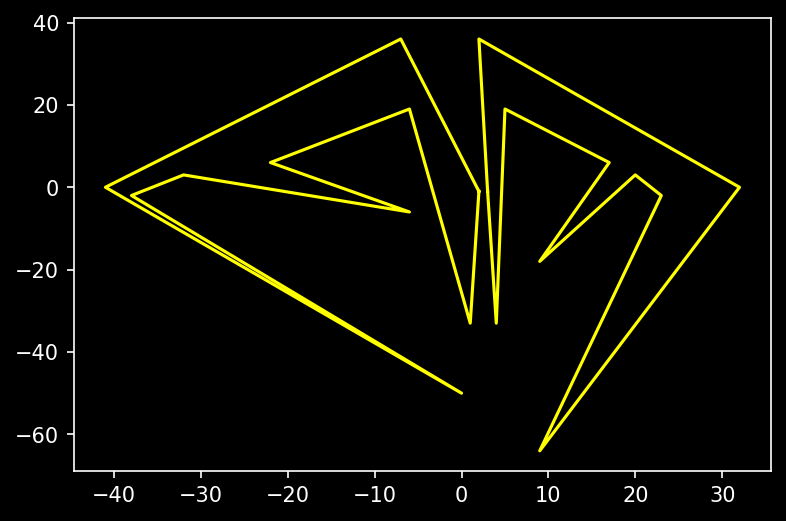

In [122]:
vector_data = """
ENER24:
	ICALVE
	CALVEC 2,-1
	.BRITE=VARBRT
	CALVEC -7,24.
	CALVEC -29.,0
	CALVEC 0,-32.
	CALVEC -26.,-2
	CALVEC -20.,3
	CALVEC -6,-6
	CALVEC -16.,6
	CALVEC -6,13.
	CALVEC 1,-21.
	CALVEC 2,-1
	.BRITE=0
	CALVEC 3,-1
	.BRITE=VARBRT
	CALVEC 2,24.
	CALVEC 20.,0
	CALVEC 9,-40.
	CALVEC 17.,-2
	CALVEC 14.,3
	CALVEC 9,-12.
	CALVEC 11.,6
	CALVEC 5,13.
	CALVEC 4,-21.
	CALVEC 3,-1
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="yellow")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


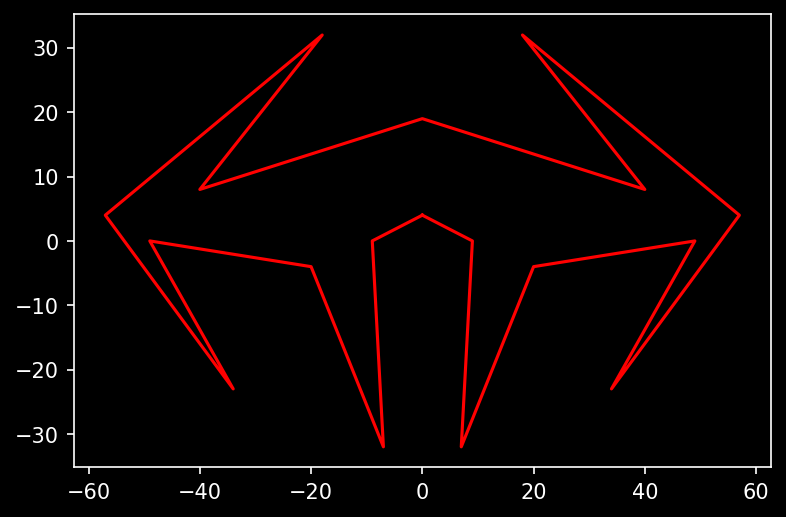

In [190]:
vector_data = """
ENER41:
	ICALVE
	CALVEC 0,4
	.BRITE=VARBRT
	CALVEC -9,0
	CALVEC -7,-20.
	CALVEC -14.,-4
	CALVEC -31.,0
	CALVEC -22.,-17.
	CALVEC -39.,4
	CALVEC -12.,20.
	CALVEC -28.,8
	CALVEC 0,13.
	CALVEC 28.,8
	CALVEC 12.,20.
	CALVEC 39.,4
	CALVEC 22.,-17.
	CALVEC 31.,0
	CALVEC 14.,-4
	CALVEC 7,-20.
	CALVEC 9,0
	CALVEC 0,4
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


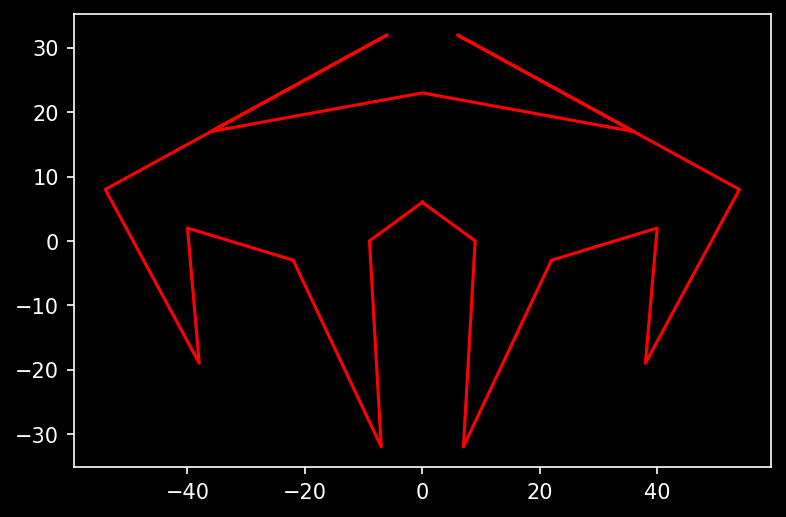

In [191]:
vector_data = """
ENER42:
	ICALVE
	CALVEC 0,6
	.BRITE=VARBRT
	CALVEC -9,0
	CALVEC -7,-20.
	CALVEC -16.,-3
	CALVEC -28.,2
	CALVEC -26.,-13.
	CALVEC -36.,8
	CALVEC -6,20.
	CALVEC -24.,11.
	CALVEC 0,17.
	CALVEC 24.,11.
	CALVEC 6,20.
	CALVEC 36.,8
	CALVEC 26.,-13.
	CALVEC 28.,2
	CALVEC 16.,-3
	CALVEC 7,-20.
	CALVEC 9,0
	CALVEC 0,6
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


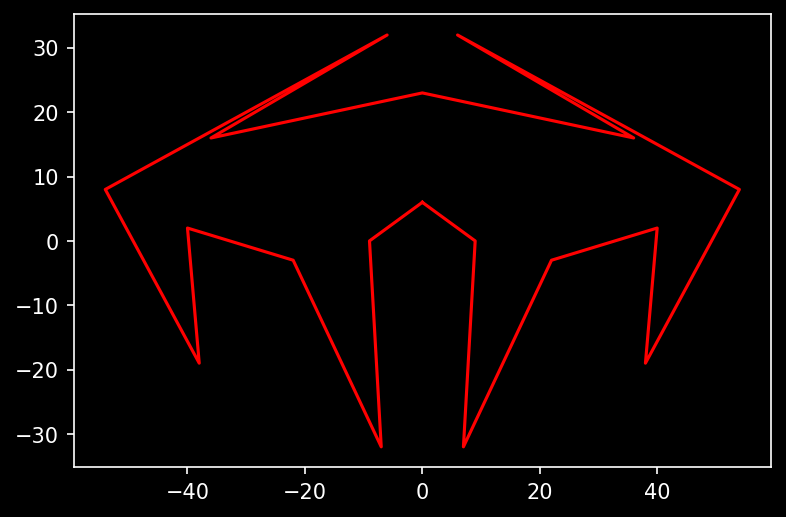

In [192]:
vector_data = """
ENER43:
	ICALVE
	CALVEC 0,6
	.BRITE=VARBRT
	CALVEC -9,0
	CALVEC -7,-20.
	CALVEC -16.,-3.
	CALVEC -28.,2
	CALVEC -26.,-13.
	CALVEC -36.,8
	CALVEC -6,20.
	CALVEC -24.,10.
	CALVEC 0,17.
	CALVEC 24.,10.
	CALVEC 6,20.
	CALVEC 36.,8
	CALVEC 26.,-13.
	CALVEC 28.,2
	CALVEC 16.,-3
	CALVEC 7,-20.
	CALVEC 9,0
	CALVEC 0,6
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data, default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


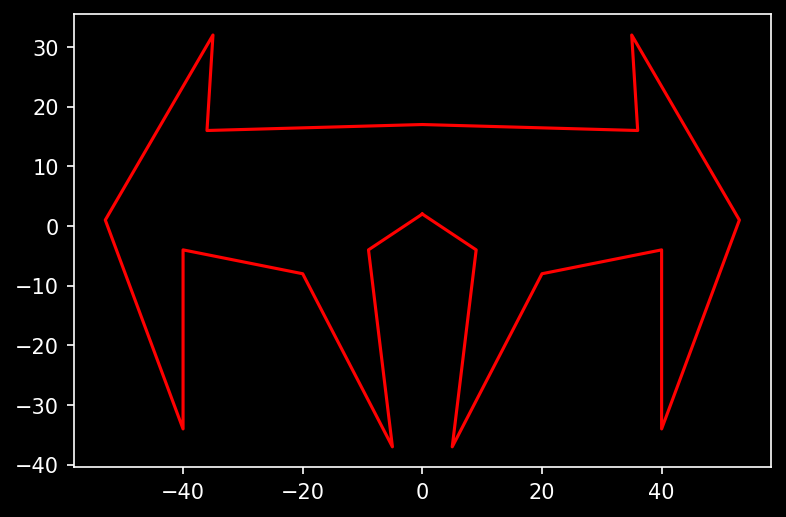

In [193]:
vector_data = """
ENER44:
	ICALVE
	CALVEC 0,2
	.BRITE=VARBRT
	CALVEC -9,-4
	CALVEC -5,-25.
	CALVEC -14.,-8
	CALVEC -28.,-4
	CALVEC -28.,-22.
	CALVEC -35.,1
	CALVEC -23.,20.
	CALVEC -24.,10.
	CALVEC 0,11.
	CALVEC 24.,10.
	CALVEC 23.,20.
	CALVEC 35.,1
	CALVEC 28.,-22.
	CALVEC 28.,-4
	CALVEC 14.,-8
	CALVEC 5,-25.
	CALVEC 9,-4
	CALVEC 0,2
	.BRITE=0
	CALVEC NXE,0
	RTSL
"""
vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


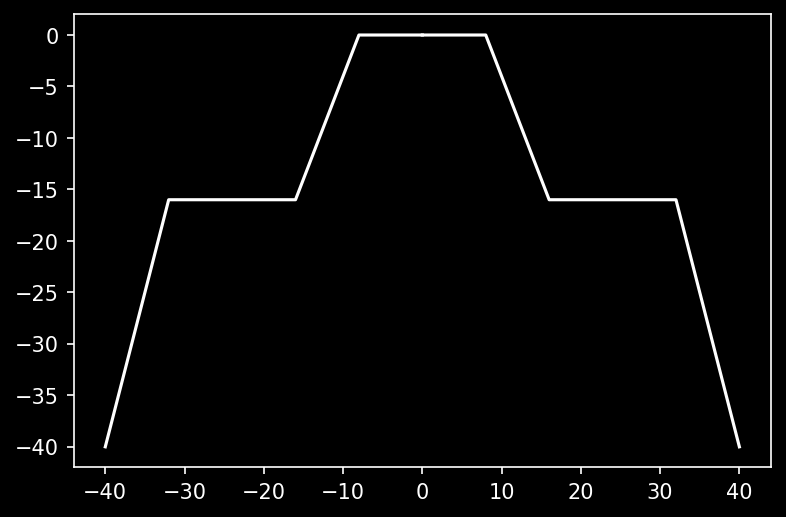

In [127]:
vector_data = """
GUNPIC:
    VCTR 0,0,6
    VCTR -8,0,6
	VCTR -8,-10,6
	VCTR -10,0,6
	VCTR -8,-18,6
	VCTR 50,0,0
	VCTR -8,18,6
	VCTR -10,0,6
	VCTR -8,10,6
	VCTR -8,0,6
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


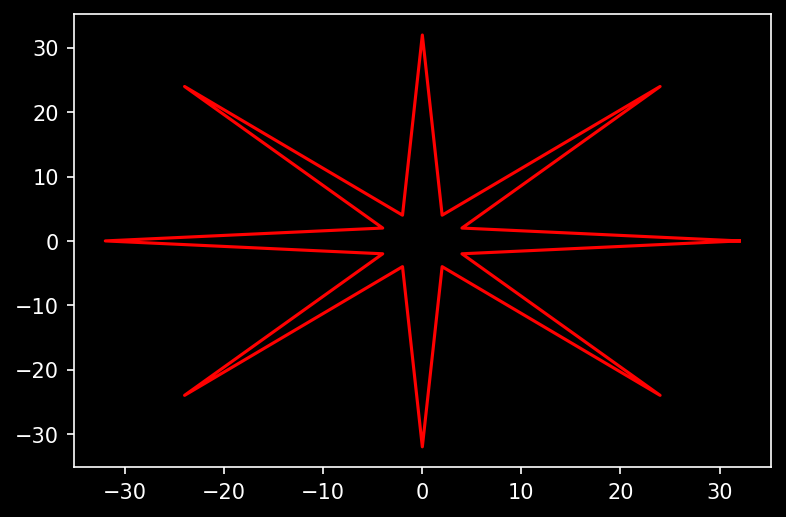

In [128]:
vector_data = """
EXPLOP:
	ICALVE
	.BRITE=0
	CALVEC 20.,0
	.BRITE=VARBRT
	CALVEC 4,2
	CALVEC 18.,18.
	CALVEC 2,4
	CALVEC 0,20.
	CALVEC -2,4
	CALVEC -18.,18.
	CALVEC -4,2
	CALVEC -20.,0
	CALVEC -4,-2
	CALVEC -18.,-18.
	CALVEC -2,-4
	CALVEC 0,-20.
	CALVEC 2,-4
	CALVEC 18.,-18.
	CALVEC 4,-2
	CALVEC 20.,0
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)


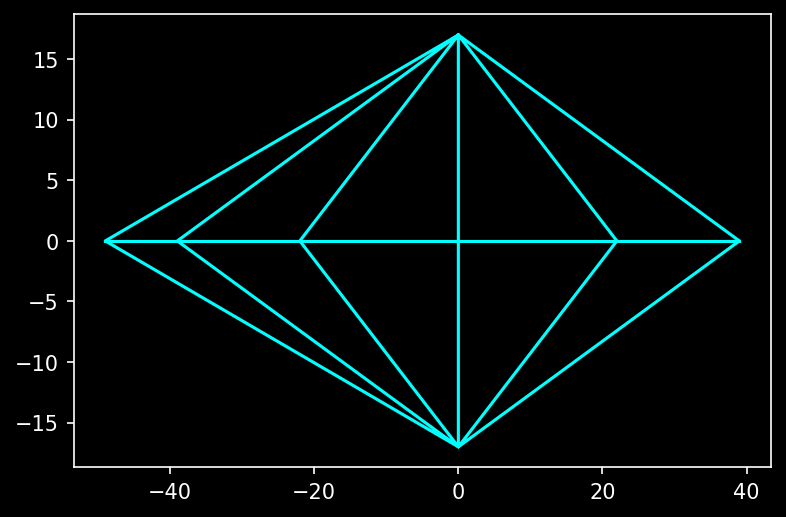

In [129]:
# HIGH=11
msauce_macro = """
.MACRO MSAUCE ...P1,...P2,...P3,...P4,...P5,...P6
	ICALVE
	CALVEC 0,.HIGH
	.BRITE=VARBRT
	CALVEC ...P1,0
	CALVEC 0,-.HIGH
	CALVEC ...P2,0
	CALVEC 0,.HIGH
	CALVEC ...P3,0
	CALVEC 0,-.HIGH
	CALVEC ...P4,0
	CALVEC 0,.HIGH
	CALVEC ...P5,0
	CALVEC 0,-.HIGH
	CALVEC ...P6,0
	CALVEC 0,.HIGH
	.BRITE=0
	CALVEC ...P6,0
	.BRITE=VARBRT
	CALVEC ...P1,0
	RTSL
"""

def_data = """
SAUPIC:	MSAUCE -31.,-27.,-16.,0,16.,27.
"""

def resolve_data(def_data):
    pic = msauce_macro
    pic = pic.replace("HIGH","11")
    parms = [x.replace('.','') for x in def_data.split()[2].split(',')]
    for i,x in enumerate(parms):
        pic = pic.replace(f"...P{i+1}",x)
    return pic

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


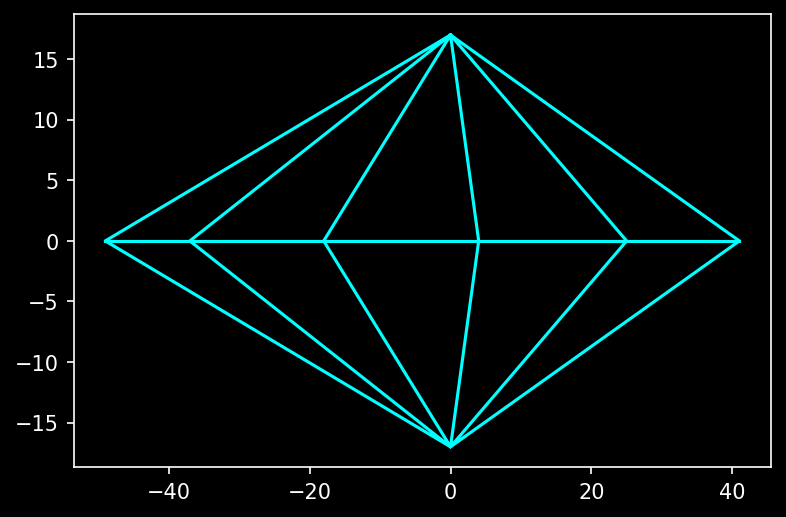

In [130]:
def_data = """
SA2PIC:	MSAUCE -31.,-25.,-12.,4,19.,29.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


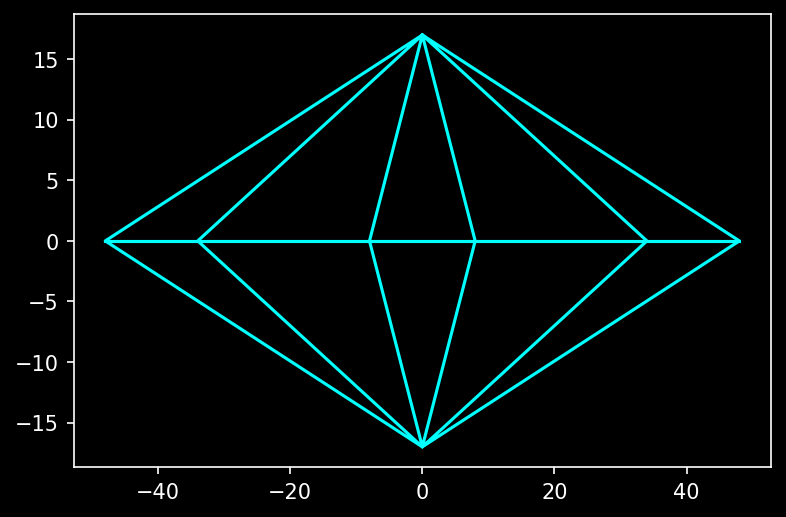

In [131]:
def_data = """
SA3PIC:
	MSAUCE -30.,-22.,-8,8,22.,30.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


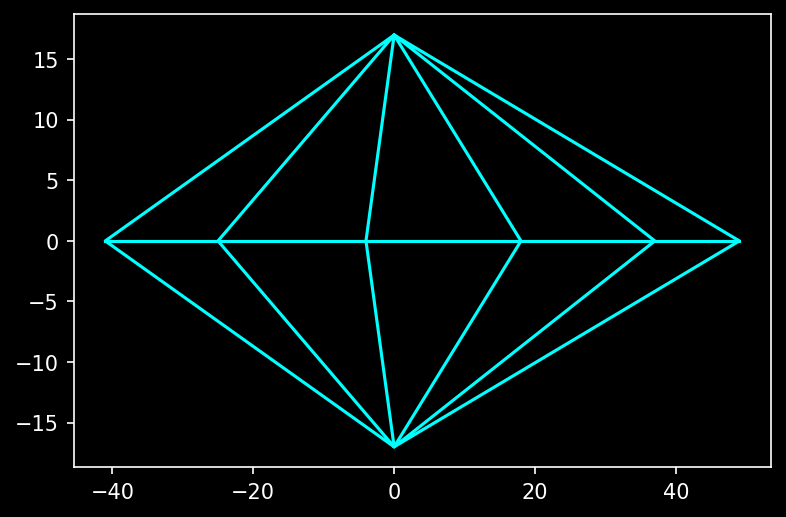

In [132]:
def_data = """
SA4PIC:
	MSAUCE -29.,-19.,-4,12.,25.,31.
"""

pic = resolve_data(def_data)
vectors = parse_vector_commands(pic,default_color="cyan")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


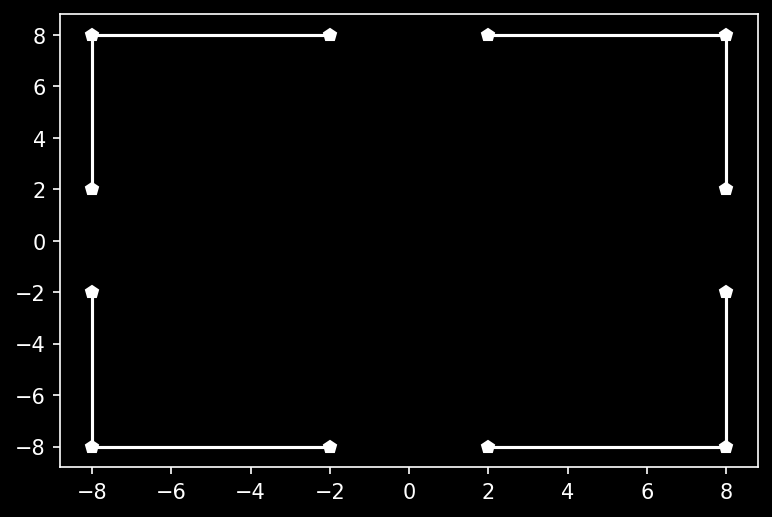

In [133]:
GURAD	="8"
GUBAR	="6"
GUBL	="4"
vector_data = """
GU2PIC:	
	CNTR
	VCTR GURAD,2,0
	VCTR 0,GUBAR,6
	VCTR -GUBAR,0,6
	VCTR -GUBL,0,0
	VCTR -GUBAR,0,6
	VCTR 0,-GUBAR,6
	VCTR 0,-GUBL,0
	VCTR 0,-GUBAR,6
	VCTR GUBAR,0,6
	VCTR GUBL,0,0
	VCTR GUBAR,0,6
	VCTR 0,GUBAR,6
	RTSL
""".replace("GUBAR",GUBAR).replace("GURAD",GURAD).replace("GUBL",GUBL)

vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


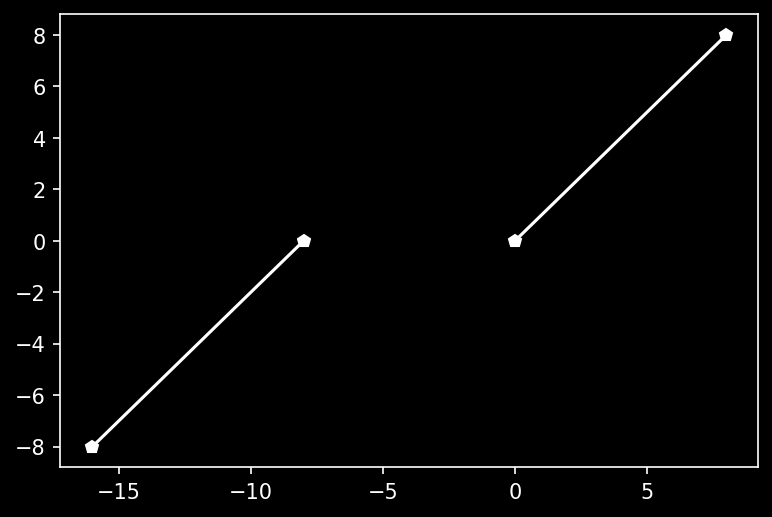

In [134]:
GURAD	=8
GUBAR	=6
GUBL	=4
vector_data = ("""
GU3PIC:
	CNTR
	VCTR GURAD,GURAD,0
	VCTR -2*GURAD,-2*GURAD,6
	VCTR 2*GURAD,0,0
	VCTR -2*GURAD,2*GURAD,6
	RTSL
""".replace("-2*GURAD",str(-1*GURAD))
   .replace("2*GURAD",str(-1*GURAD))
   .replace("GUBAR",str(GUBAR)).replace("GURAD",str(GURAD))
   .replace("GUBL",str(GUBL)))

vectors = parse_vector_commands(vector_data,default_color="red")
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


[21, 16, 14, 12]


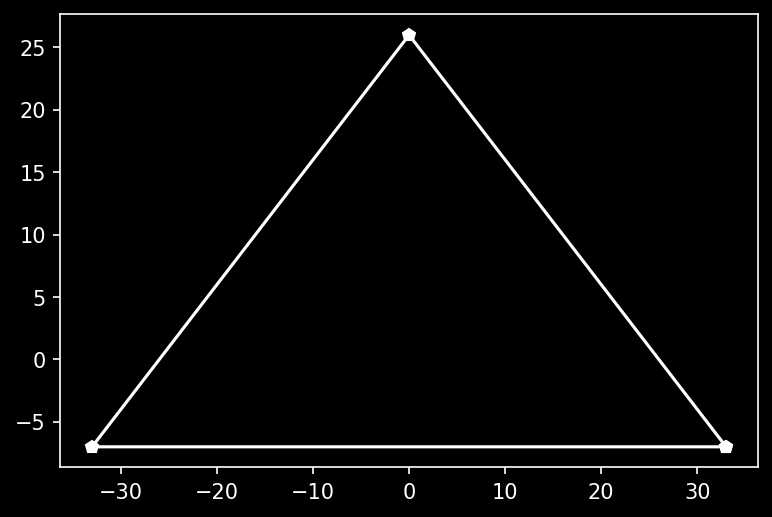

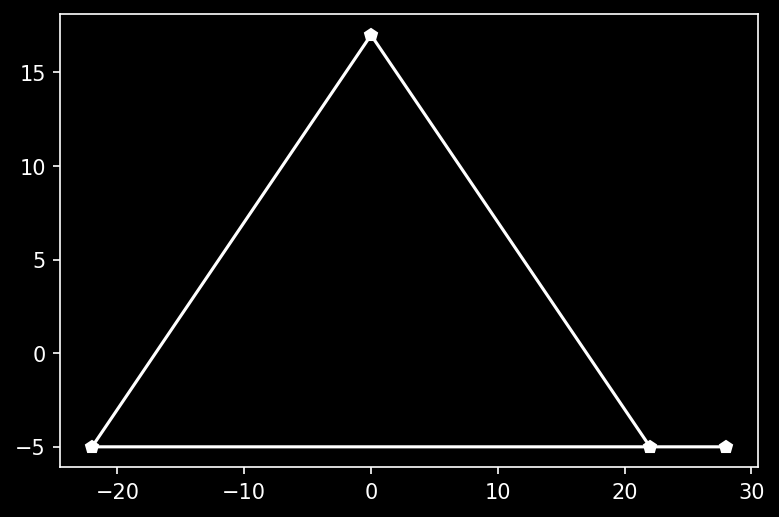

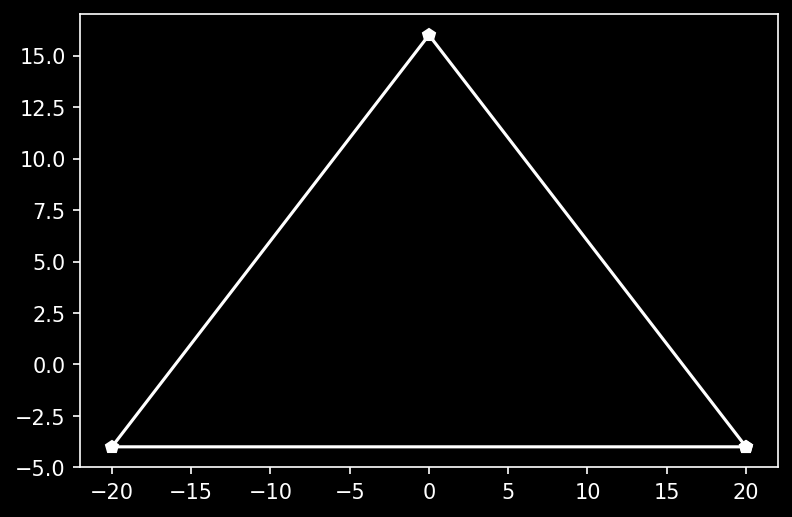

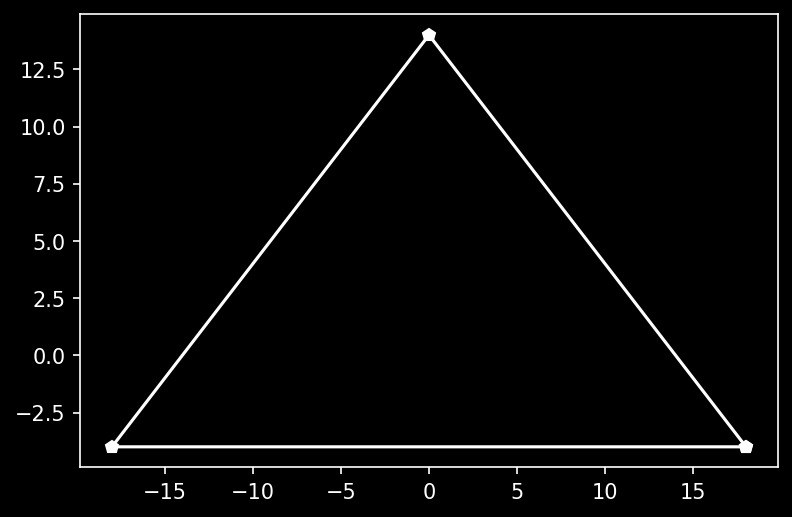

In [135]:

macro_data = """
.MACRO FORTMAC .FS
VCTR .FS,-<.FS/3>,0
VCTR -.FS,.FS,6
VCTR -.FS,-.FS,6
VCTR 2*.FS,0,6
VCTR -.FS,<.FS/3>,0
RTSL
.ENDM
.IF NE,0
"""

fort_data = """
FROW0: FORTMAC 15
FROW1: FORTMAC 10
FROW2: FORTMAC 0E
FROW3: FORTMAC 0C
"""
FSS = [int(x.split()[2],16) for x in fort_data.splitlines()[1:]]
print(FSS)
for FS in FSS:
    vector_data = (
        macro_data.replace("<.FS/3>", str(int(FS/3)))
       .replace("2*.FS", str(int(2*FS)))
       .replace(".FS", str(FS))
    )
    vectors = parse_vector_commands(vector_data,default_color="red")
    vertices = vectors_to_coords(vectors)
    plot_vertices(vertices,"p")


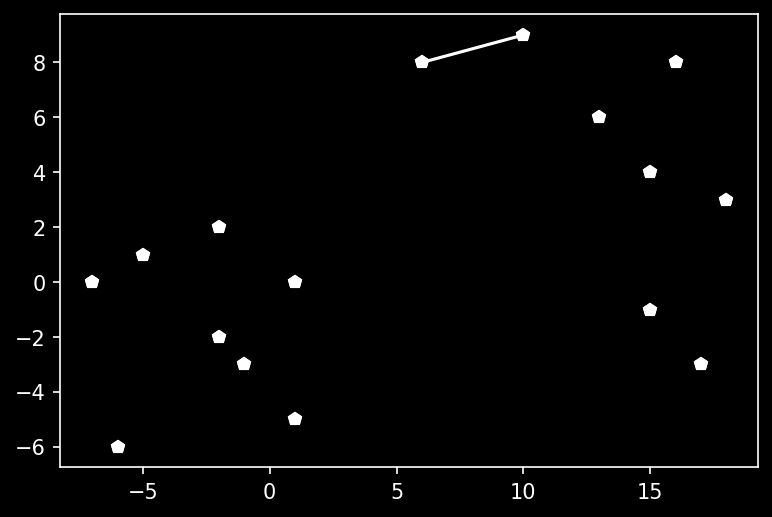

In [136]:
vector_data = """
SHRPIC:
	VCTR 1,0,0
	VDOT
	VCTR -3,2,0
	VDOT
	VCTR -3,-1,0
	VDOT
	VCTR -2,-1,0
	VDOT
	VCTR 1,-6,0
	VDOT
	VCTR 4,4,0
	VDOT
	VCTR 1,-1,0
	VDOT
	VCTR 2,-2,0
	VDOT
	VCTR 0E,4,0
	VDOT
	VCTR 2,-2,0
	VDOT
	VCTR 1,6,0
	VDOT
	VCTR -3,1,0
	VDOT
	VCTR -2,2,0
	VDOT
	VCTR 3,2,0
	VDOT
	VCTR -6,1,0
	VDOT
	VCTR -4,-1,6
	VDOT
	RTSL
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"p")


## Images from ANVGAN.MAC

This file contains the vectors for all alphanumerics. The values given are decimal rather than hexadecimal.

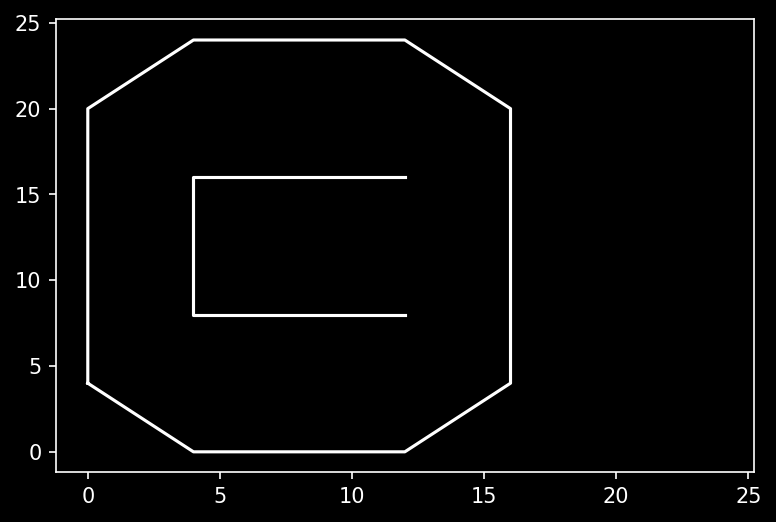

In [137]:
def vctr(color,x,y,i=""):
    x,y=int(x),int(y)
    if i == "0":
        return (x,y,"BLACK")
    return (x,y,colors.get(color,color))

vector_data = """
COPYR:
	VCTR 0,4,0
	VCTR 0,16,.BRITE
	VCTR 4,4,.BRITE
	VCTR 8,0,.BRITE
	VCTR 4,-4,.BRITE
	VCTR 0,-16,.BRITE
	VCTR -4,-4,.BRITE
	VCTR -8,0,.BRITE
	VCTR -4,4,.BRITE
	VCTR 12,4,0
	VCTR -8,0,.BRITE
	VCTR 0,8,.BRITE
	VCTR 8,0,.BRITE
	VCTR 12,-16,0
"""
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices)

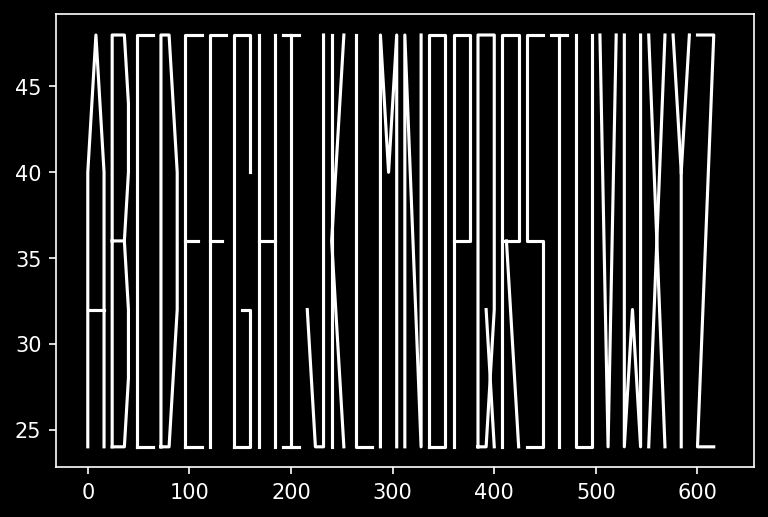

In [138]:
import re
anvgan = open("../src/ANVGAN.MAC",'r').read()
letters = [tuple(x.split(':')) for x in re.split('CHAR\.',anvgan)[1:27]]
letters = {x:y for x,y in letters}
vector_data = "\tVCTR 0,24,0\n"
for c, vec_data in letters.items():
    vector_data += vec_data
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


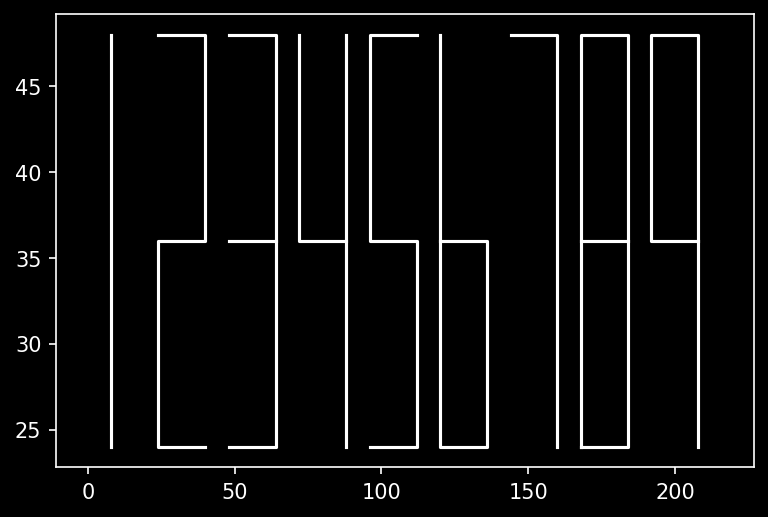

In [139]:
import re
anvgan = open("../src/ANVGAN.MAC",'r').read()
numbers = [tuple(x.split(':'))[:2] for x in re.split('CHAR\.',anvgan)[30:39]]
numbers = {x:y for x,y in numbers}
vector_data = "\tVCTR 0,24,0\n"
for c, vec_data in numbers.items():
    vector_data += vec_data
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")


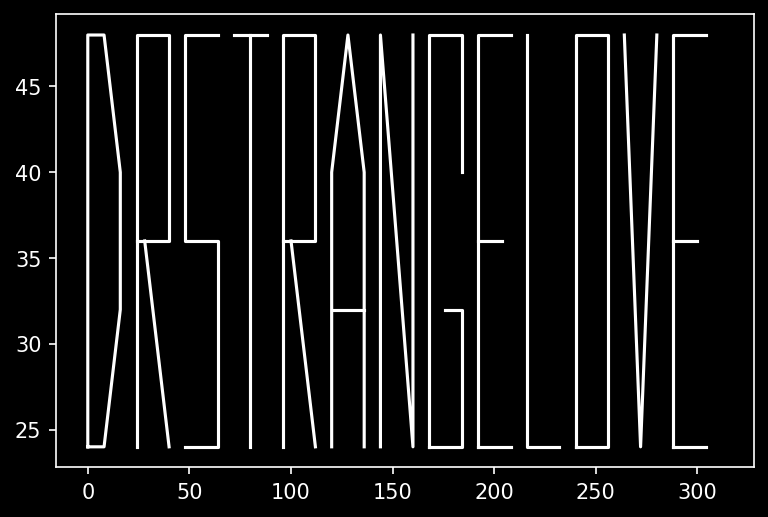

In [140]:
vector_data = "VCTR 0,24,0\n"
word = "DRSTRANGELOVE"
for c in word:
    vector_data += letters[c]
vectors = parse_vector_commands(vector_data)
vertices = vectors_to_coords(vectors)
plot_vertices(vertices,"")

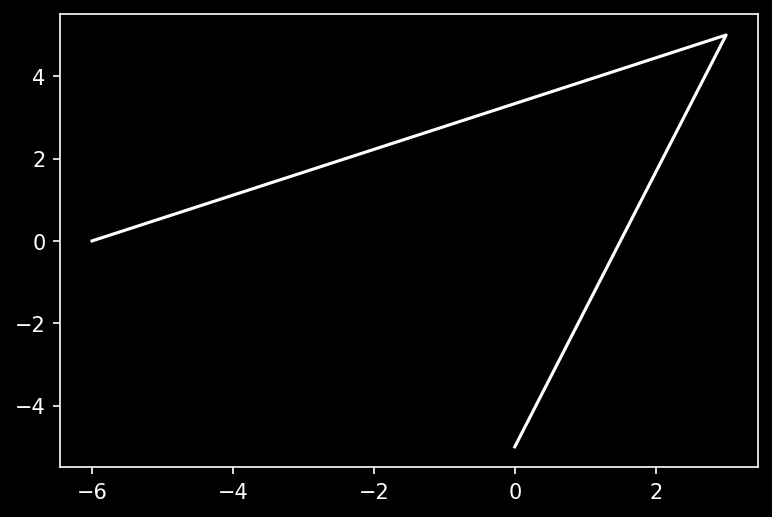

In [141]:
vertices = [
    (int(x.split()[1].split(',')[0]),
     int(x.split()[1].split(',')[1]),
     "WHITE")
     for x in """
	.BYTE -6,0,0
	.BYTE 3,5,4
	.BYTE 3,5,-4
	.BYTE 0,-5,0
""".splitlines()[1:]]
plot_vertices(vertices,"")

## Mysterious Stuff in ALVROM.MAC

Not entirely clear what this stuff is meant to be. I guess they are x,y,z vertices?
```
ALVROM - ALIENS ROM VG PICTURES	ATARI MAC65 VM03.09  00:00:02 PAGE 32
OBJECT TABLES - VERTICES

     1                                          .SBTTL OBJECT TABLES - VERTICES
     2
     3
     4         0010                             .RADIX 16
     6   01D2    04                     NOPTBL: .BYTE ENDNOP-NOPTBL
     7   01D3    00    00    00                 .BYTE 0,0,0
     8   01D6                           ENDNOP:
     9   01D6    13                     DSHTBL: .BYTE ENDDSH-DSHTBL
    10   01D7    FE    00    02                 .BYTE -2,0,2
    11   01DA    02    00    FE                 .BYTE 2,0,-2
    12   01DD    FE    00    FE                 .BYTE -2,0,-2
    13   01E0    02    00    02                 .BYTE 2,0,2
    14   01E3    00    02    00                 .BYTE 0,2,0
    15   01E6    00    FE    00                 .BYTE 0,-2,0
    16   01E9                           ENDDSH:
    17   01E9    13                     DS2TBL: .BYTE ENDDS2-DS2TBL
    18   01EA    FE    01    01                 .BYTE -2,1,1
    19   01ED    02    FF    FF                 .BYTE 2,-1,-1
    20   01F0    FE    FF    FF                 .BYTE -2,-1,-1
    21   01F3    02    01    01                 .BYTE 2,1,1
    22   01F6    00    01    FF                 .BYTE 0,1,-1
    23   01F9    00    FF    01                 .BYTE 0,-1,1
    24   01FC                           ENDDS2:
    25   01FC    13                     DS3TBL: .BYTE ENDDS3-DS3TBL
    26   01FD    FE    02    00                 .BYTE -2,2,0
    27   0200    02    FE    00                 .BYTE 2,-2,0
    28   0203    FE    FE    00                 .BYTE -2,-2,0
    29   0206    02    02    00                 .BYTE 2,2,0
    30   0209    00    00    FE                 .BYTE 0,0,-2
    31   020C    00    00    02                 .BYTE 0,0,2
    32   020F                           ENDDS3:
    33   020F    13                     DS4TBL: .BYTE ENDDS4-DS4TBL
    34   0210    FE    01    FF                 .BYTE -2,1,-1
    35   0213    02    FF    01                 .BYTE 2,-1,1
    36   0216    FE    FF    01                 .BYTE -2,-1,1
    37   0219    02    01    FF                 .BYTE 2,1,-1
    38   021C    00    FF    FF                 .BYTE 0,-1,-1
    39   021F    00    01    01                 .BYTE 0,1,1
    40   0222                           ENDDS4:
    41   0222    0D                     ESHTBL: .BYTE ENDESH-ESHTBL
    42   0223    00    FB    00                 .BYTE 0,-5,0
    43   0226    02    05    00                 .BYTE 2,5,0
    44   0229    FF    05    02                 .BYTE -1,5,2
    45   022C    FF    05    FE                 .BYTE -1,5,-2
    46   022F                           ENDESH:
    47   022F    0D                     ES2TBL: .BYTE EN2ESH-ES2TBL
    48   0230    00    FB    00                 .BYTE 0,-5,0
    49   0233    02    05    01                 .BYTE 2,5,1
    50   0236    FE    05    01                 .BYTE -2,5,1
    51   0239    00    05    FE                 .BYTE 0,5,-2
    52   023C                           EN2ESH:
    53   023C    0D                     ES3TBL: .BYTE EN3ESH-ES3TBL
    54   023D    00    FB    00                 .BYTE 0,-5,0
    55   0240    01    05    02                 .BYTE 1,5,2
    56   0243    FE    05    00                 .BYTE -2,5,0
    57   0246    01    05    FE                 .BYTE 1,5,-2
    58   0249                           EN3ESH:
ALVROM - ALIENS ROM VG PICTURES	ATARI MAC65 VM03.09  00:00:02 PAGE 32+
OBJECT TABLES - VERTICES

    59
    60   0249    0D                     ES4TBL: .BYTE EN4ESH-ES4TBL
    61   024A    00    FB    00                 .BYTE 0,-5,0
    62   024D    00    05    02                 .BYTE 0,5,2
    63   0250    FE    05    FF                 .BYTE -2,5,-1
    64   0253    02    05    FF                 .BYTE 2,5,-1
    65   0256                           EN4ESH:
    66   0256    0D                     ASTTBL: .BYTE ENDAST-ASTTBL
    67   0257    FA    00    00                 .BYTE -6,0,0
    68   025A    03    05    04                 .BYTE 3,5,4
    69   025D    03    05    FC                 .BYTE 3,5,-4
    70   0260    00    FB    00                 .BYTE 0,-5,0
    71   0263                           ENDAST:

```

Likewise this stuff. THese aren't vector commands, so what are they?

```
     1                                          .SBTTL OBJECT TABLE-SUBROUTINE TYPE
     2
     4   0263                           SAUDRW:
     5   0263    03                             TLABS 0
     6   0264    02                             TJSR CSAURT
     7   0265    FF                             OBJEND
     8
     9   0266    03                     SA2DRW: TLABS 0
    10   0267    1A                             TJSR CSAUR2
    11   0268    FF                             OBJEND
    12   0269    03                     SA3DRW: TLABS 0
    13   026A    22                             TJSR CSAUR3
    14   026B    FF                             OBJEND
    15   026C    03                     SA4DRW: TLABS 0
    16   026D    2A                             TJSR CSAUR4
    17   026E    FF                             OBJEND
    18   026F    03                     GUNDRW: TLABS 0
    19   0270    05                             TSCAL 0
    20   0271    0A                             TJSR CGUNRT
    21   0272    FF                             OBJEND
    22
    23   0273    03                     GUNDR2: TLABS 0
    24   0274    05                             TSCAL 0
    25   0275    3A                             TJSR CGUNR2
    26   0276    FF                             OBJEND
    27
    28   0277                           EX1DRW:
    29   0277    03                             TLABS 0
    30   0278    1D                             TSCAL 3
    31   0279    12                             TJSR CEXPRT
    32   027A    FF                             OBJEND
    33
    34   027B                           EX2DRW:
    35   027B    03                             TLABS 0
    36   027C    15                             TSCAL 2
    37   027D    12                             TJSR CEXPRT
    38   027E    FF                             OBJEND
    39
    40   027F                           EX3DRW:
    41   027F    03                             TLABS 0
    42   0280    0D                             TSCAL 1
    43   0281    12                             TJSR CEXPRT
    44   0282    FF                             OBJEND
    45
    46   0283                           EX4DRW:
    47   0283    03                             TLABS 0
    48   0284    05                             TSCAL 0
    49   0285    12                             TJSR CEXPRT

```

In [142]:
verts = [(-6,0),(0,3),(5,4),(3,5),(-4,0),(-5,0)]
verts = [(x,y,"WHITE") for x,y in verts]

vector_data = """
ASTDRW:
	TLABS 0
	SBRITE 0E0
	TVCTR 1
	TVCTR 2
	TVCTR 3
	TVCTR 0
	TVCTR 2
	SBRITE 0
	TVCTR 3
	SBRITE 0E0
	TVCTR 1
	OBJEND
"""